In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import VanillaSampler, PartitionedSampler, ApproximatedSampler, LayerWiseApproxSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, rbmpy.mnist, pickle, rbmpy.rbm, os, logging, rbmpy.sampler
from sklearn.linear_model import Perceptron
from sklearn.neural_network import BernoulliRBM

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)


%matplotlib inline


## Helper methods
    
        
def key_for_visible(v):
    return "v{}".format(v)

def perform(h_a, h_b, v,sampler ,times, num_gibbs=500):
    """Runing times many times and generate visibles based on the supplied hiddens, the number of gibbs sampler per time
        Can also be specified
    """
    result = Counter()
    for i in range(times):
        gen_v = sampler.v_to_v(h_a,h_b, v, num_gibbs=num_gibbs)
        key = key_for_visible(gen_v)
        result[key] += 1
             
    return result
    

def goodnight(model, sampler, hours_of_sleep, num_gibbs_per_hour):
    """Generate a dictionary of reconstructions to the number of times they occurred"""
    result_dict = Counter()
    v_prime = sampler.dream(model, num_gibbs_per_hour)
    reconstruction_dict = {} # the actual reconstructions that occurred
    for i in range(hours_of_sleep):
        v_prime = sampler.dream(model, num_gibbs_per_hour)
        result_dict[key_for_visible(v_prime)] += 1
        reconstruction_dict[key_for_visible(v_prime)] = v_prime
    return result_dict, reconstruction_dict


def build(training, n_hid, n_vis, epochs, l_r):
    model = RBM(n_hid,n_vis,1)
    s = VanillaSampler(model)
    t = VanillaTrainier(model, s)
    if l_r:
        t.train(epochs, training, l_r)
    else:
        t.train(epochs, training)
    return model
    
def build_and_eval(training, n_hid, n_vis,epochs = 100000, n_reconstructions = 1000, n_gibbs_p_r = 100,l_r = None, acceptance_penalty = 40, tries = 1):
    """Build and evaluate a model for reconising x bits on in however many n_vis"""
    model = build(training, n_hid,n_vis,epochs, l_r)
    a,b = goodnight(model, VanillaSampler(model), n_reconstructions, n_gibbs_p_r)
    penalty = model_dream_penatly(a,training, n_reconstructions)
    
    best = (penalty, model)
    attempts = 0
    while penalty >= acceptance_penalty and attempts < tries:
        print("Attempt", attempts)
        model = build(training, n_hid,n_vis,epochs, l_r)
        a,b = goodnight(model, VanillaSampler(model), n_reconstructions, n_gibbs_p_r)
        penalty = model_dream_penatly(a,training, n_reconstructions)
        if penalty < best[0]:
            best = (penalty, model)
        attempts += 1
    
    pp.plot_dict(a, title = "Dreams for {} hidden unit model trained with x bit on in a pattern of {} many bits".format(n_hid,n_vis))
    print("Penalty For {}h:{}".format(n_hid,best[0]))
    return best[1]

def eval_partitioned(model, v, times = 1000, num_gibbs = 400, sampler = ApproximatedSampler):
    n_hid = model.num_hid()
    h_a = np.random.randint(2,size=(n_hid,))
    h_b = np.random.randint(2,size=(n_hid,))
    s = sampler(model.weights, model.weights,model.hidden_bias, model.hidden_bias)
    d = perform(h_a, h_b, v, s, times, num_gibbs)
    plotter.plot_dict(d, title="v'| {}".format(v), size = "")
    return d

def training_set_of_size(n, on_bits = 1):
    a = np.eye(n)
    for i in range(1,on_bits):
        a += np.eye(n, k=i)
    return a[:n-(on_bits-1)]  

def model_dream_penatly(result, training, times):
    # we would expect their to be equal chance of producing the things in the training set
    expected_dreams = training.shape[0]
    expected_count = times/expected_dreams
    most_common_dreams = result.most_common(expected_dreams) 

    total_diff = 0
    for dream in most_common_dreams:
        current_diff = abs(expected_count - dream[1])
        total_diff += current_diff

    return total_diff

#Readme#

Now that we know that ORBM performs excellently on 1 bit patterns (1 bit on in $1,..,n$ bits) we can take a natural next steps. 

In [2]:
train = training_set_of_size(2)
print(train)

[[ 1.  0.]
 [ 0.  1.]]


Attempt 0
Attempt 0


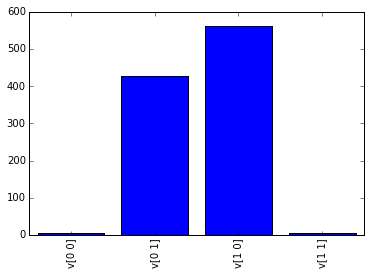

Penalty For 2h:134.0


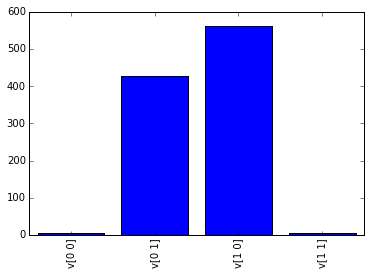

Penalty For 2h:134.0


In [3]:
model = build_and_eval(train, 2,2)

In [4]:
from sampler import FullCorrection, DirtySampler

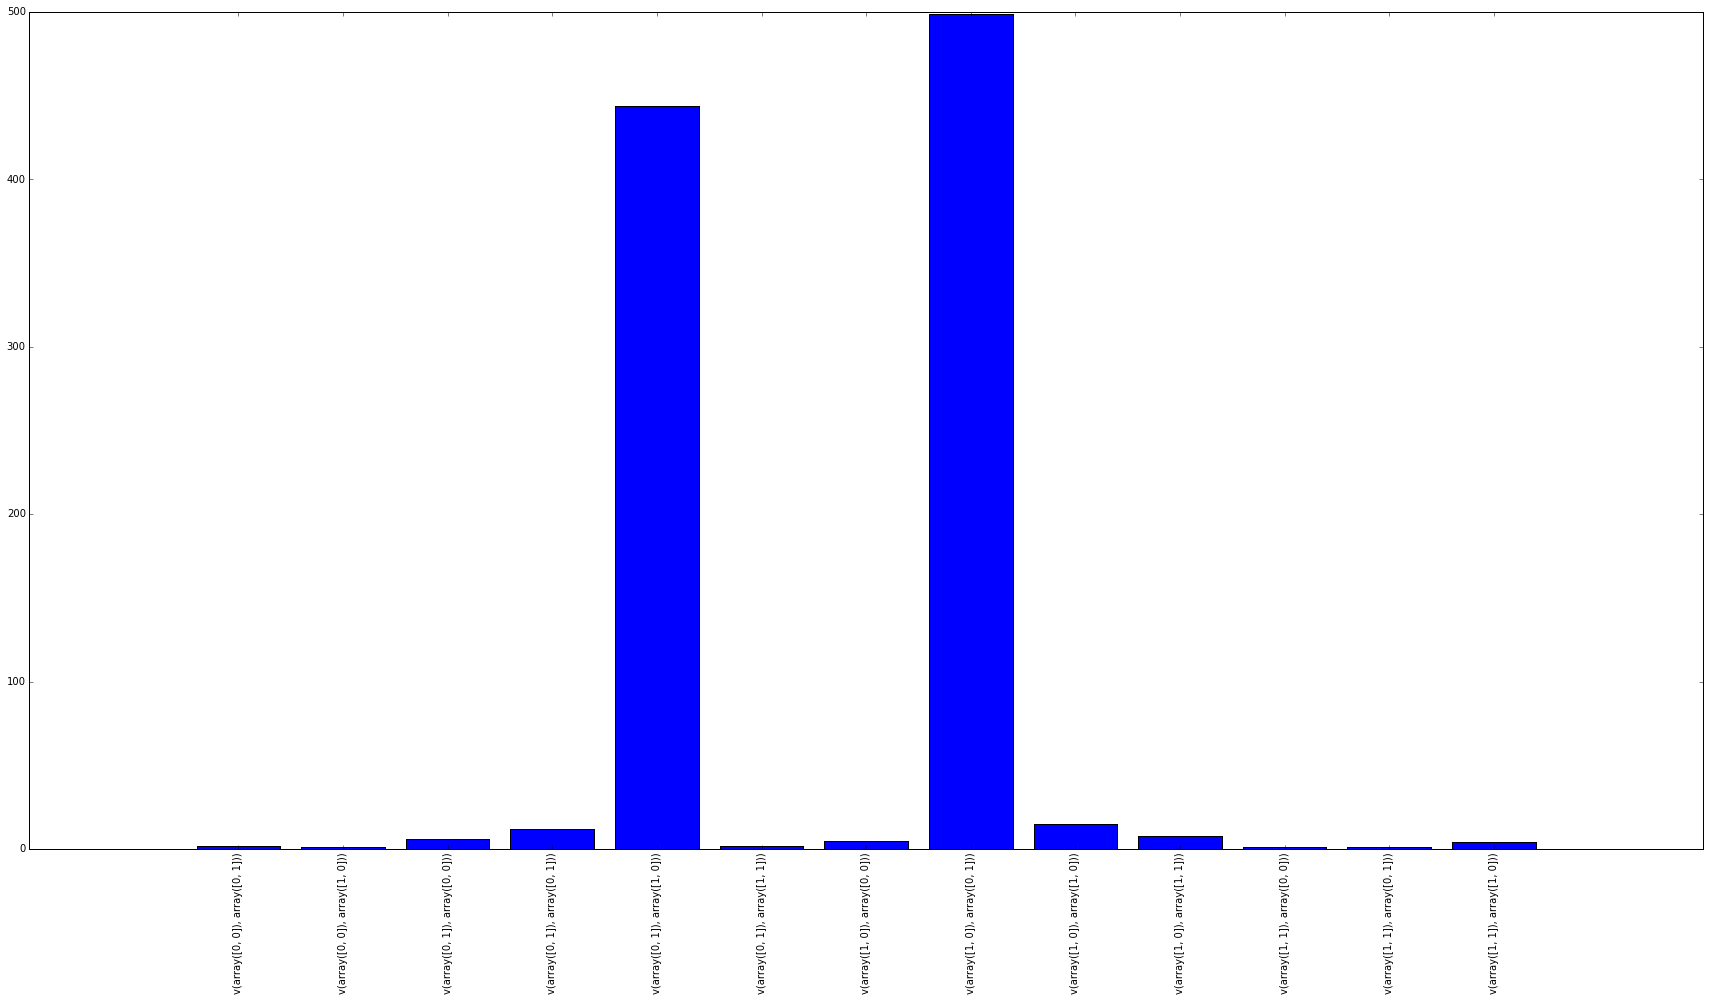

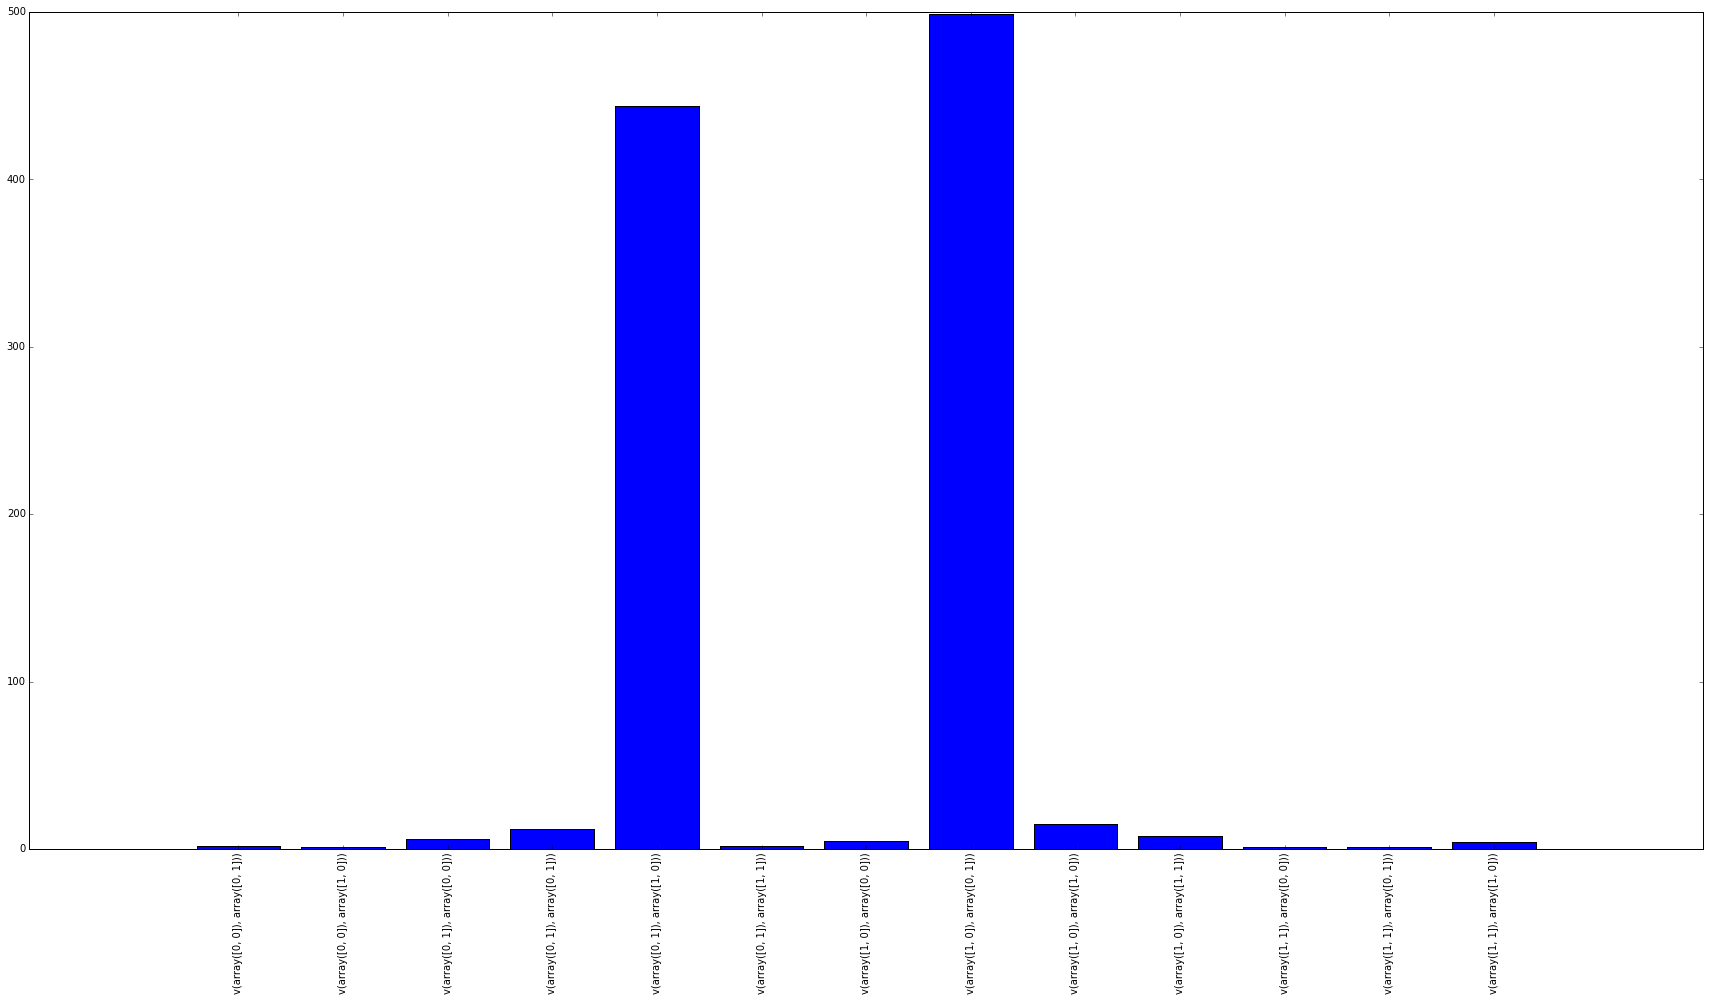

In [7]:
a = eval_partitioned(model, np.array([0,0]), sampler= DirtySampler)

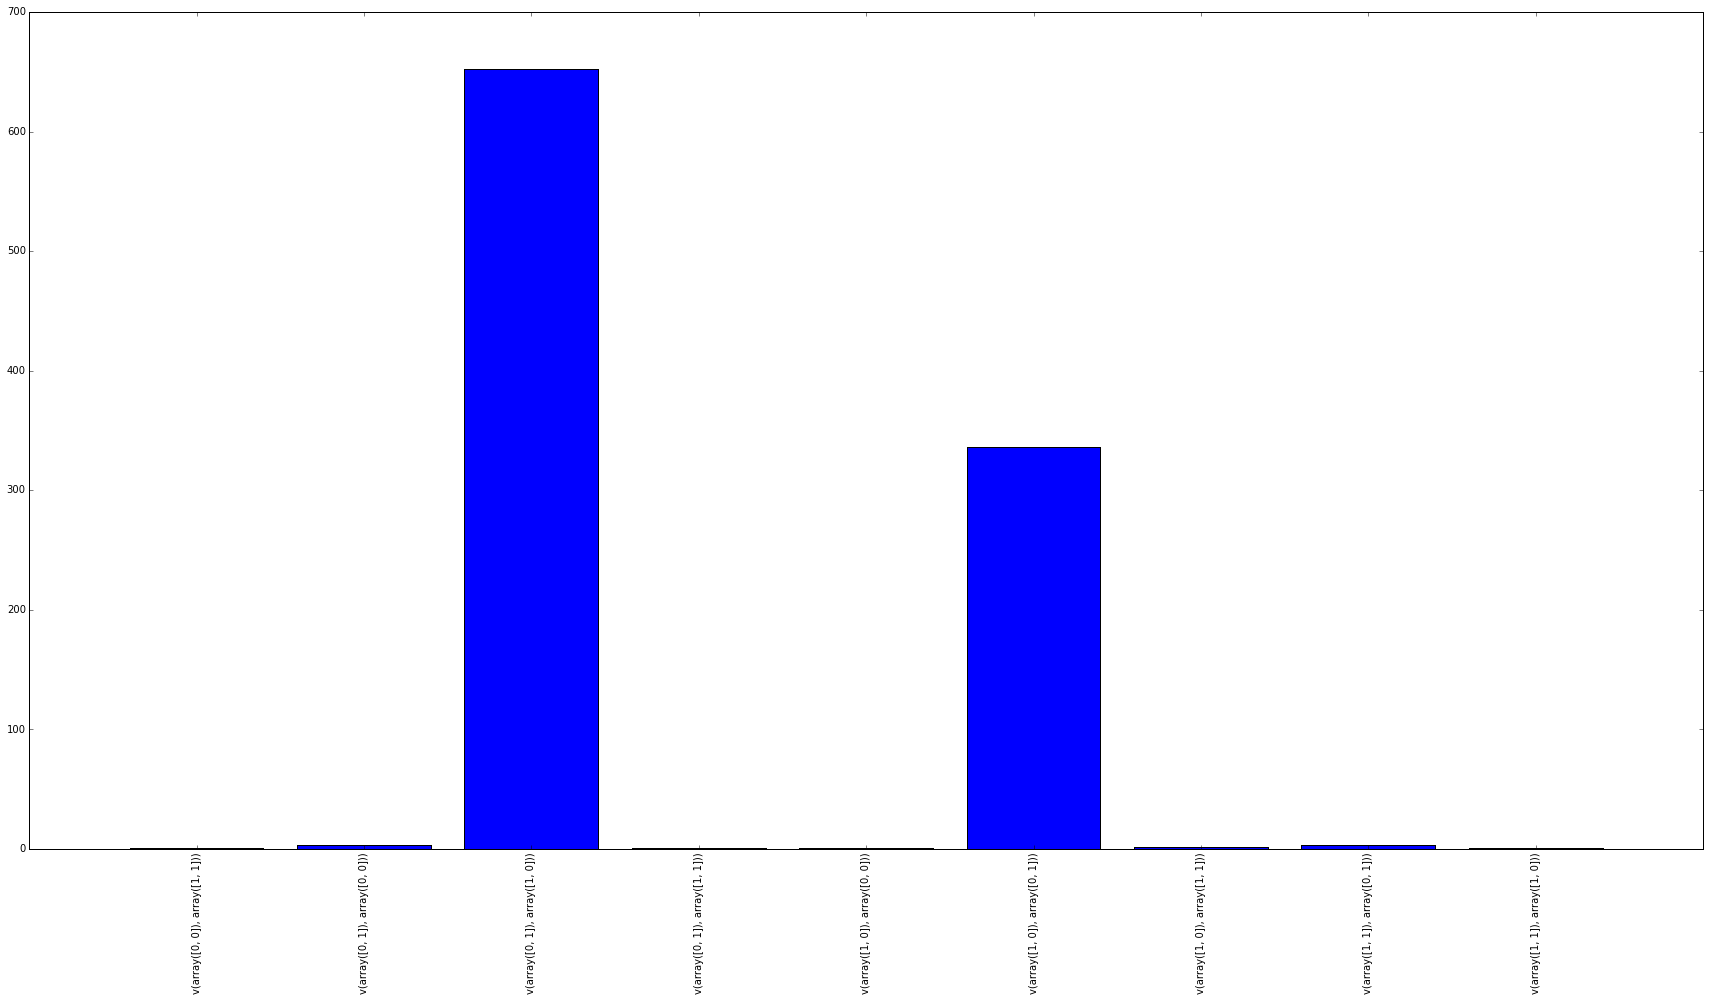

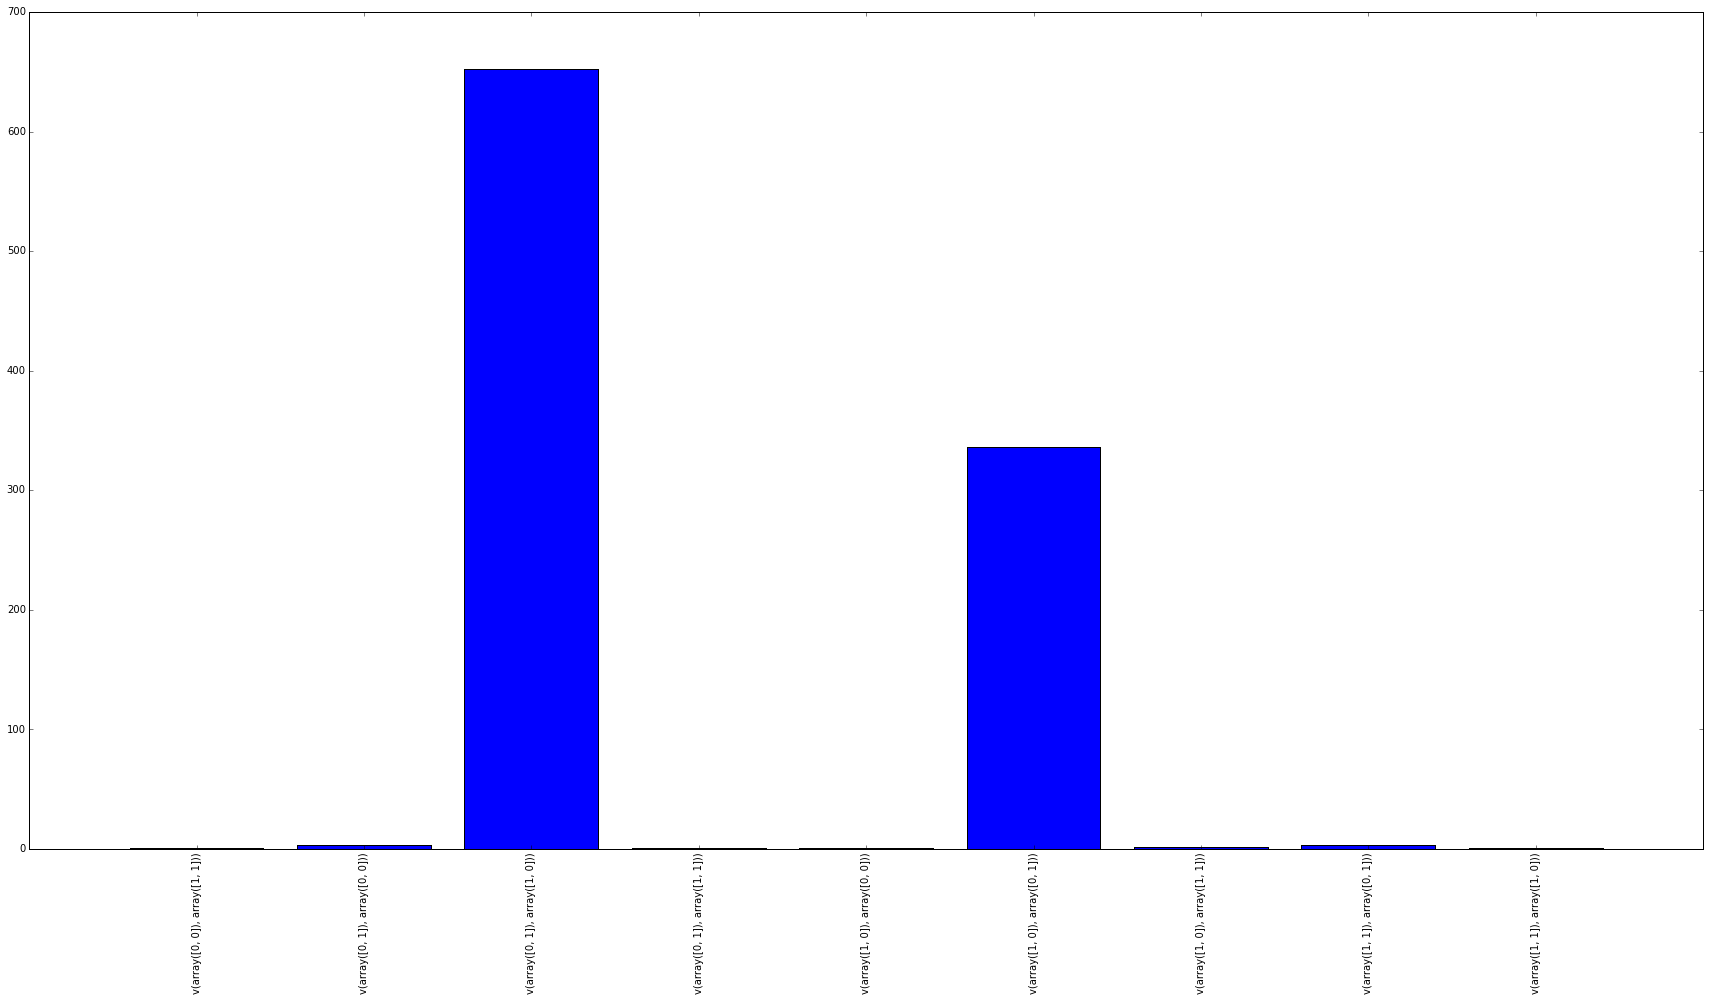

In [10]:

a = eval_partitioned(model, np.array([1,1]), sampler= ApproximatedSampler)

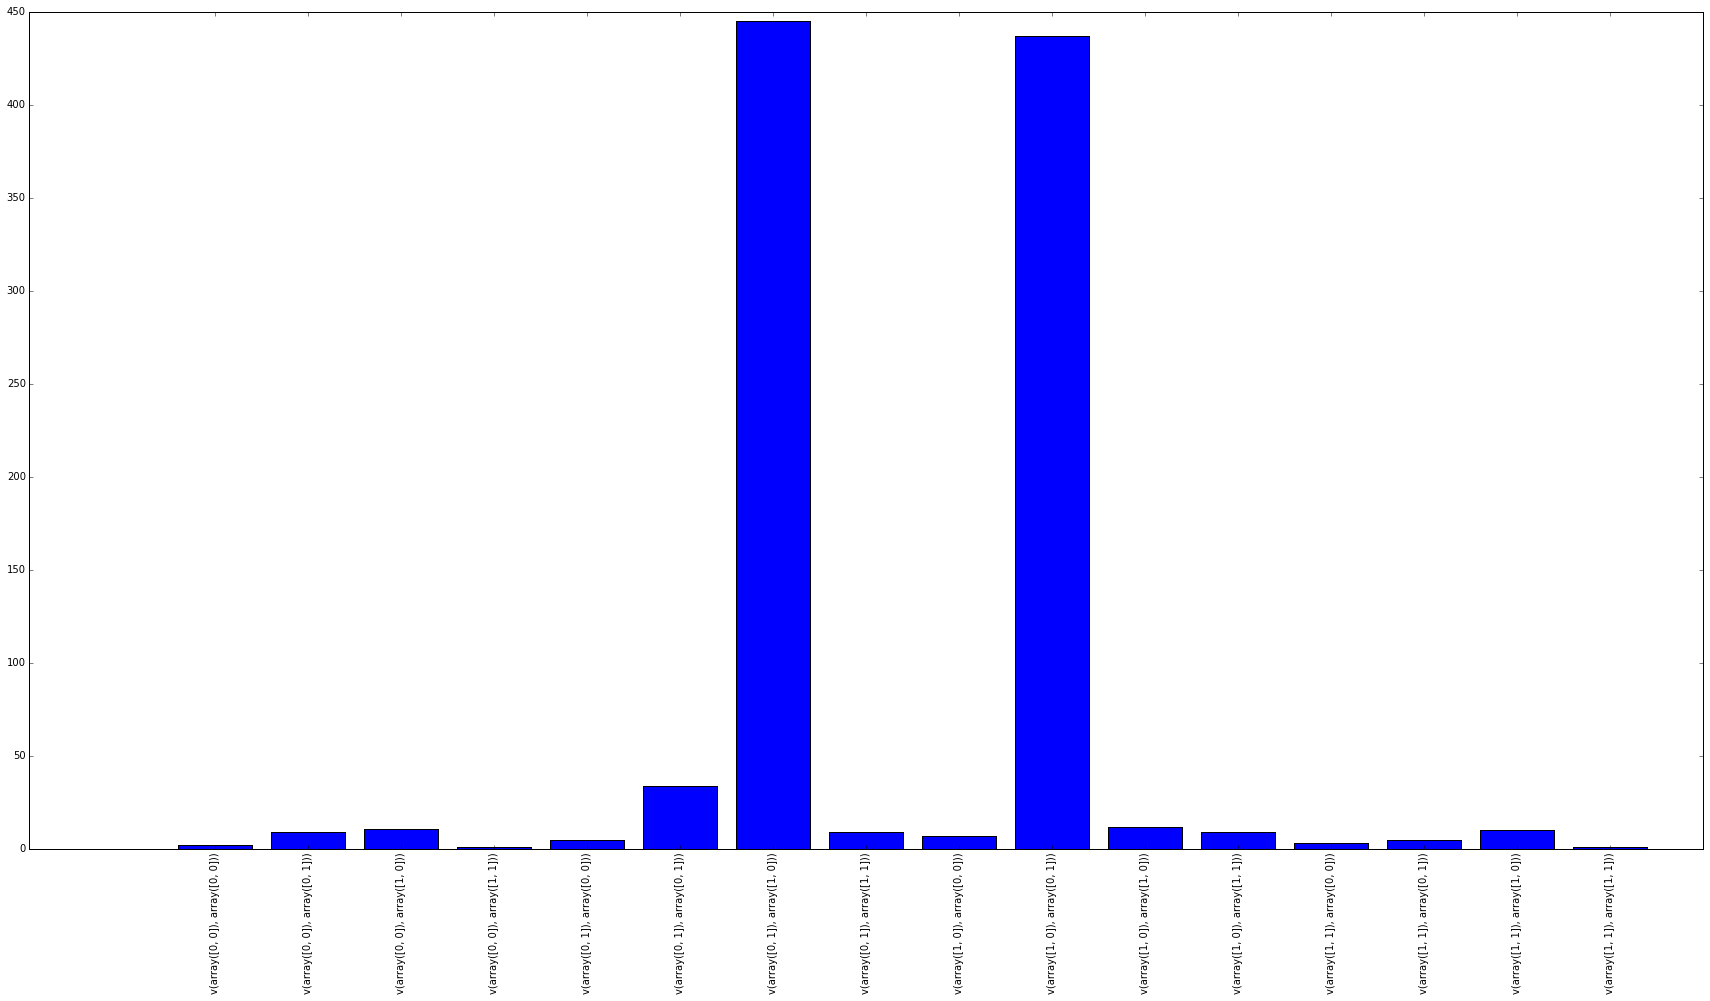

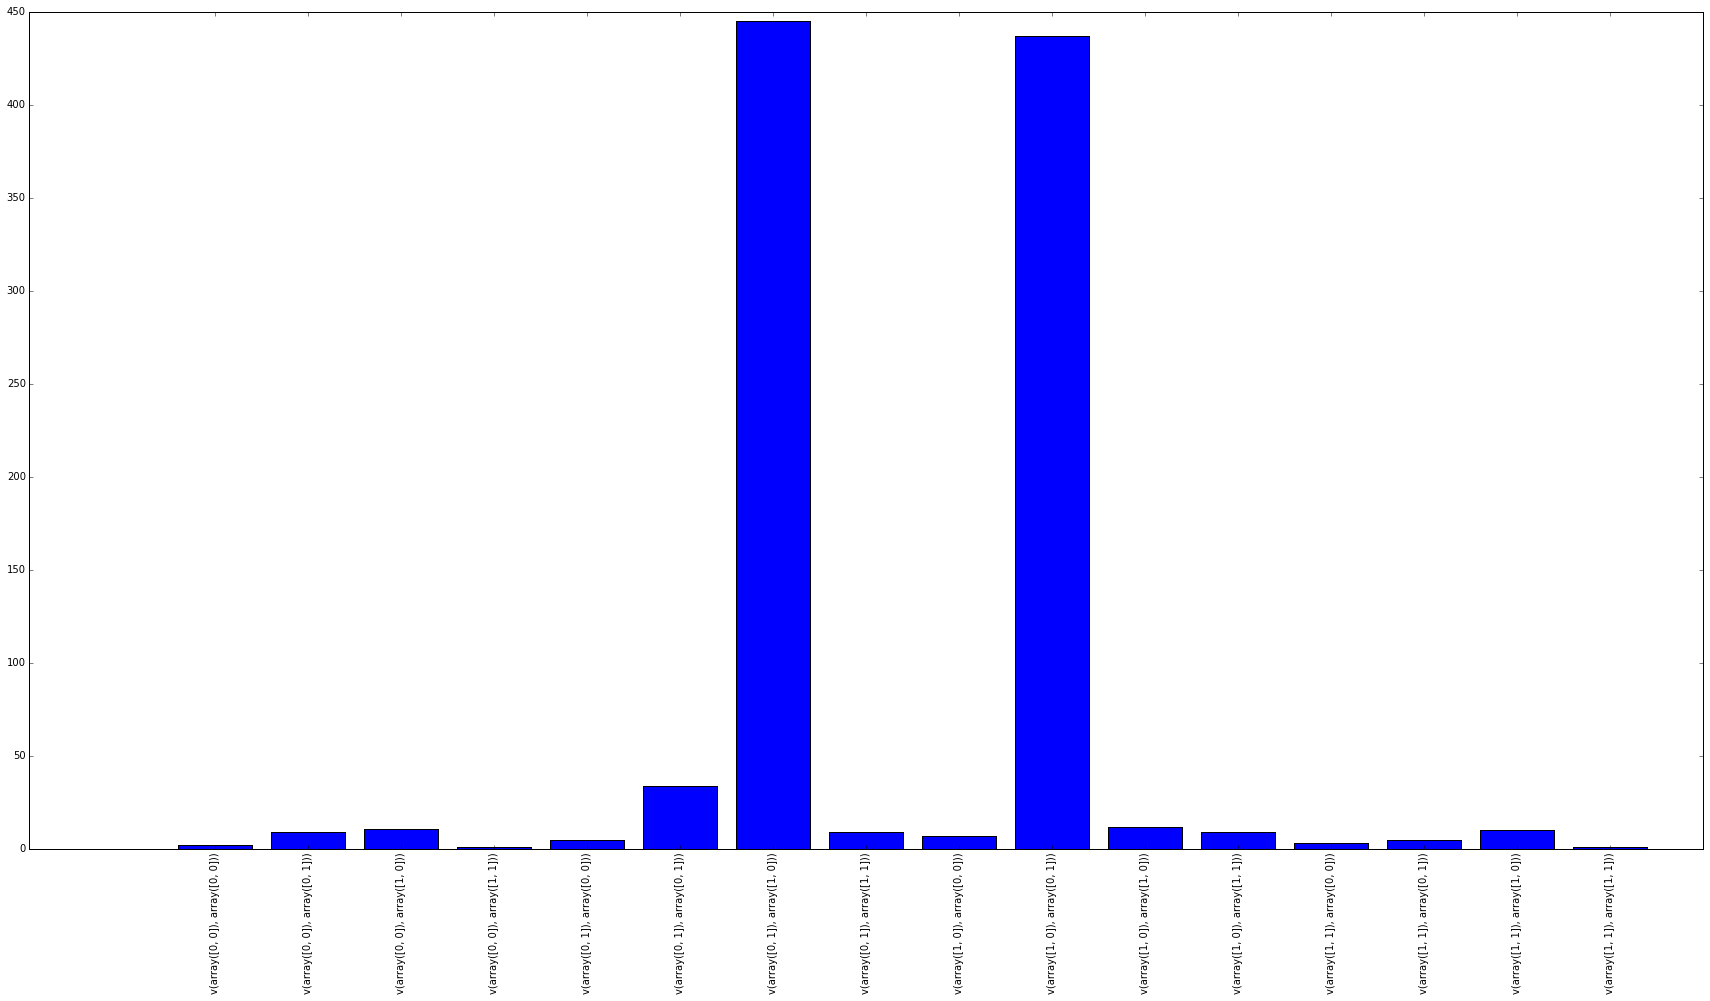

In [9]:

aa = eval_partitioned(model, np.array([1,1]), sampler = FullCorrection)

# Four Bits, One on #

In [8]:
train = training_set_of_size(4)
print(train)

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


Attempt 0
Attempt 0


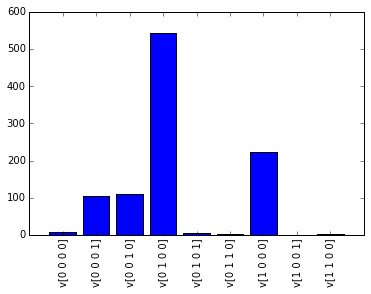

Penalty For 4h:370.0


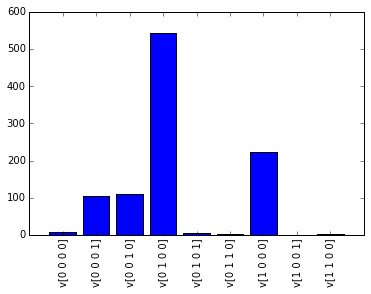

Penalty For 4h:370.0


In [9]:
model = build_and_eval(train, 4,4)

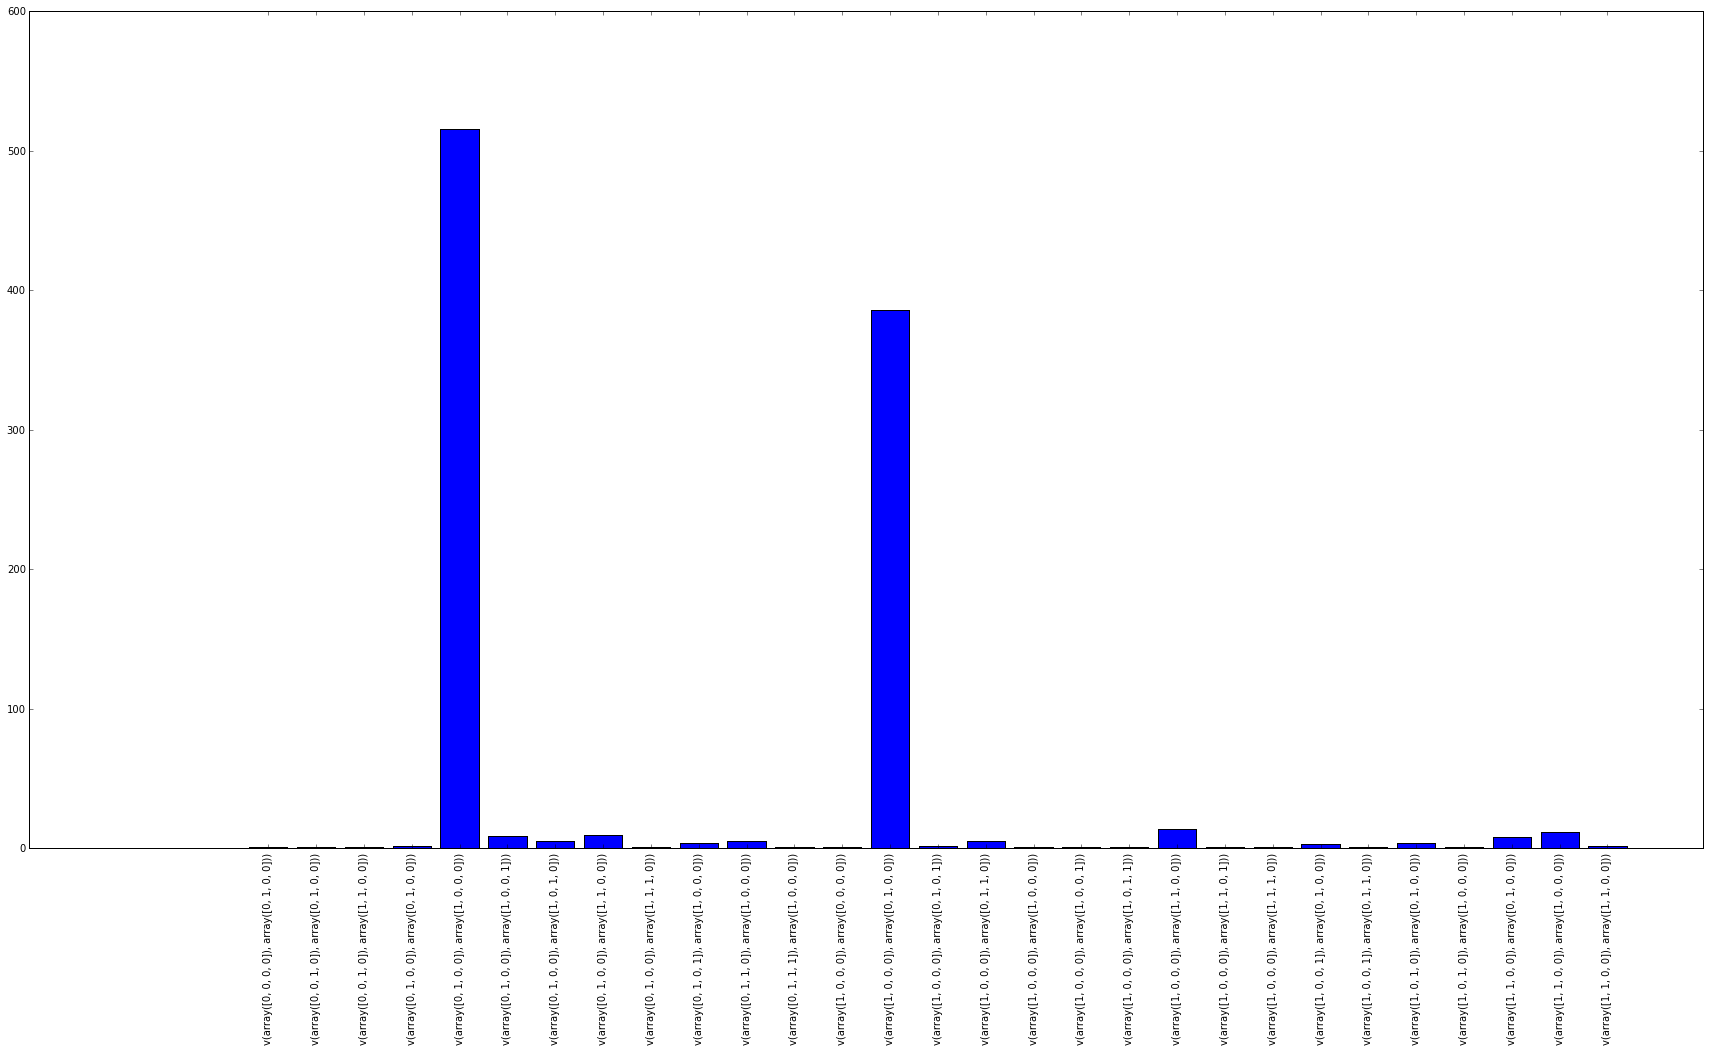

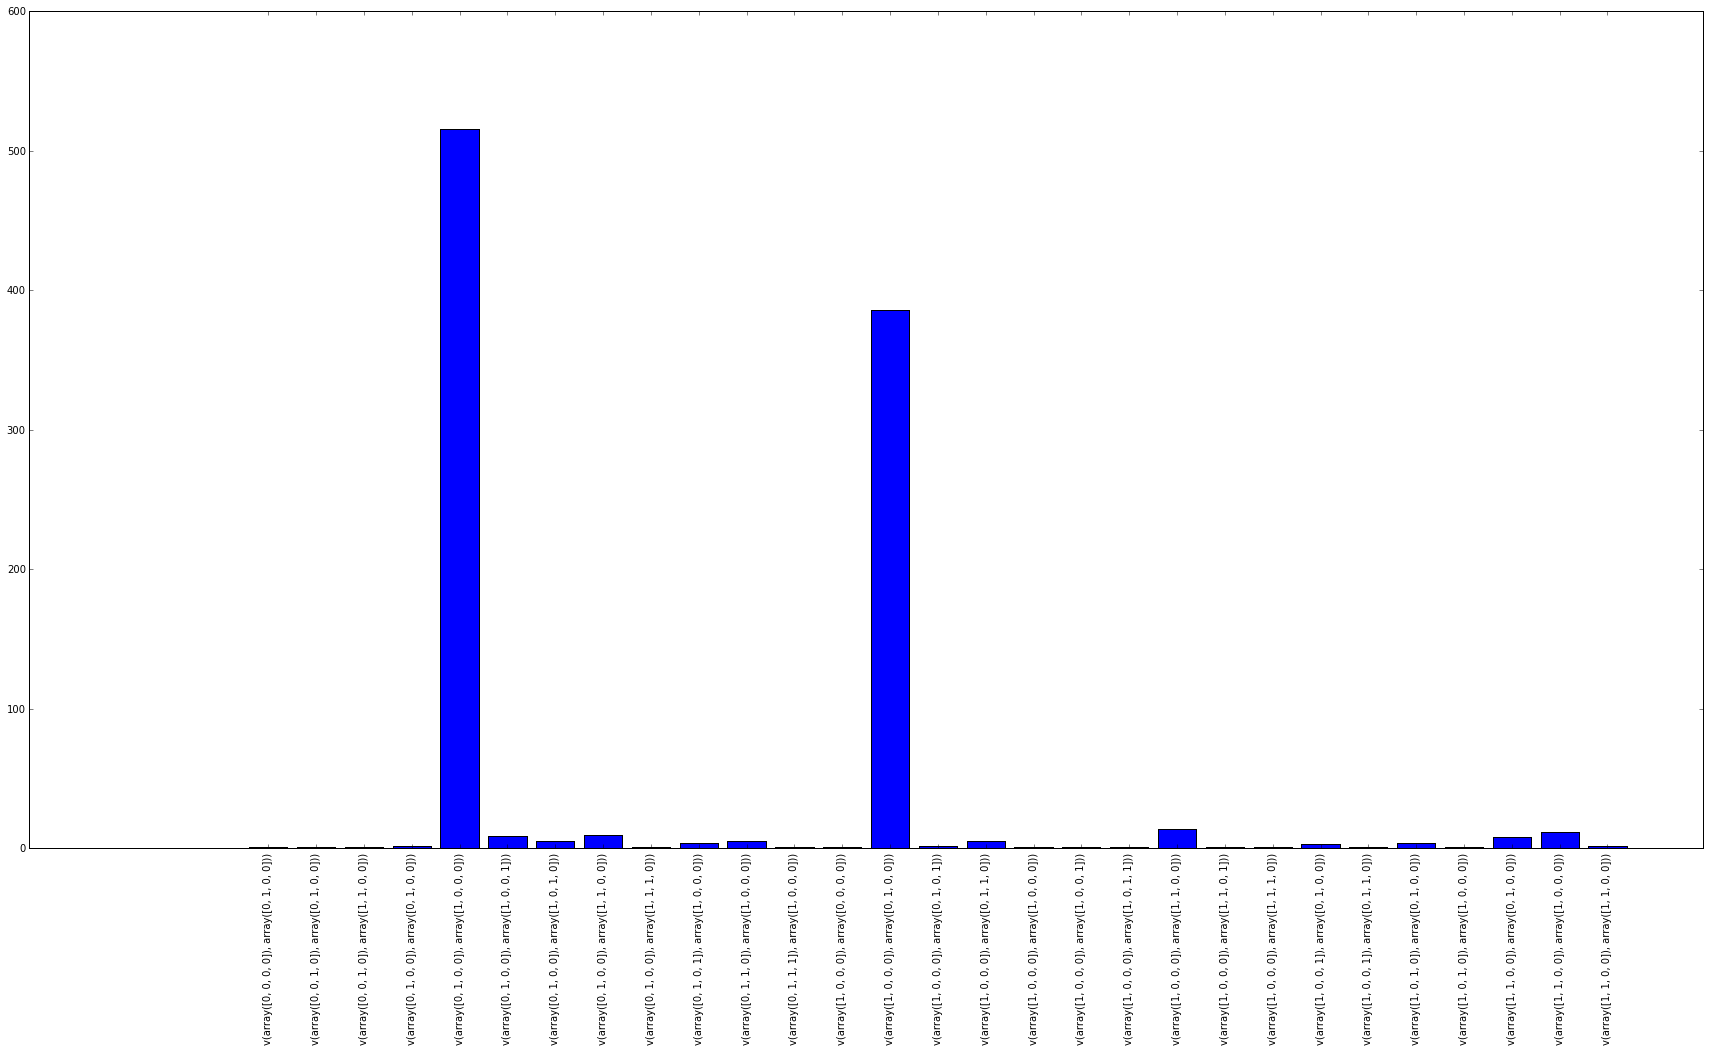

In [11]:
b = eval_partitioned(model, np.array([1,1,0,0]), num_gibbs=500, sampler = DirtySampler)

# Five Bits, One on #

In [55]:
train = training_set_of_size(5)
print(train)

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


In [54]:
model = build_and_eval(train, 5,5,epochs=100000,l_r=0.001)

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


KeyboardInterrupt: 

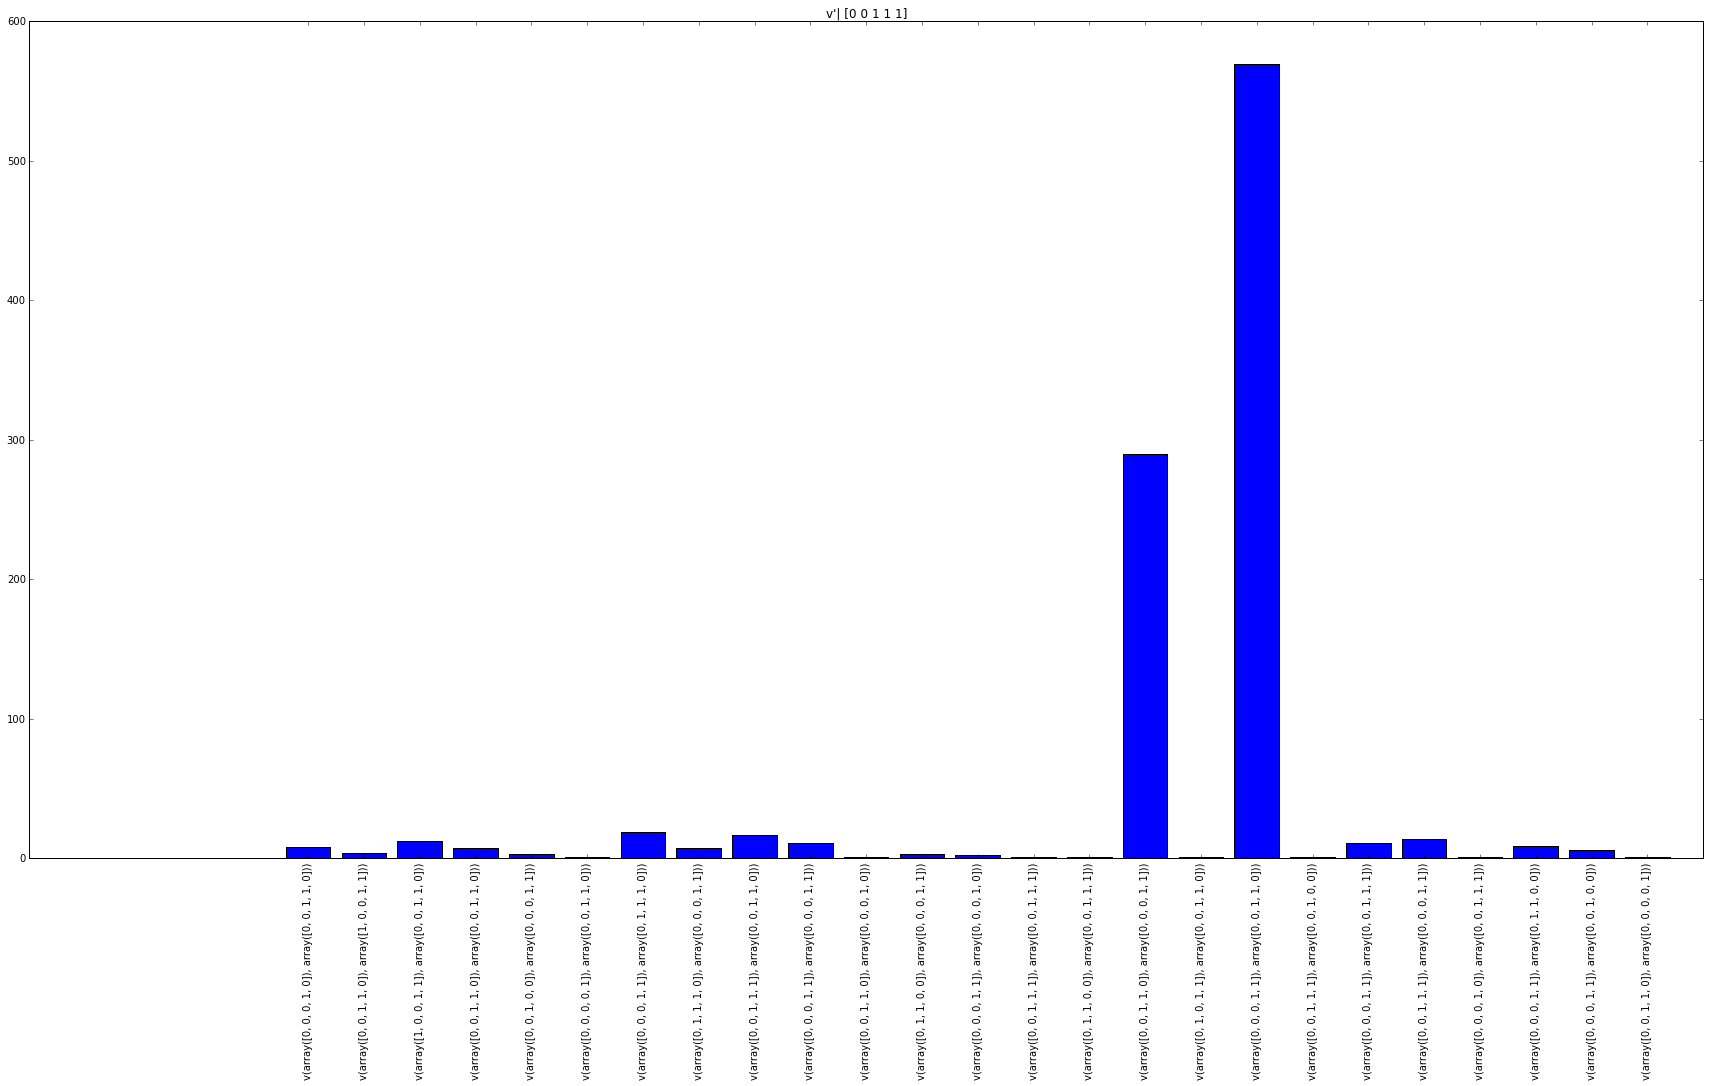

In [132]:
b = eval_partitioned(model, np.array([0,0,1,1,1]), num_gibbs=500)

# Six Bits, One On #

In [56]:
train = training_set_of_size(6)
print(train)

[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]


[[ 1.  1.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  1.  1.]]


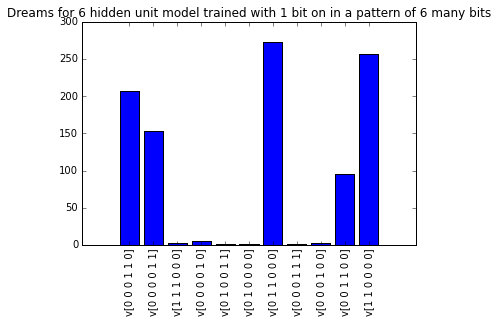

In [137]:
model = build_and_eval(train, 6,6,epochs=200000)

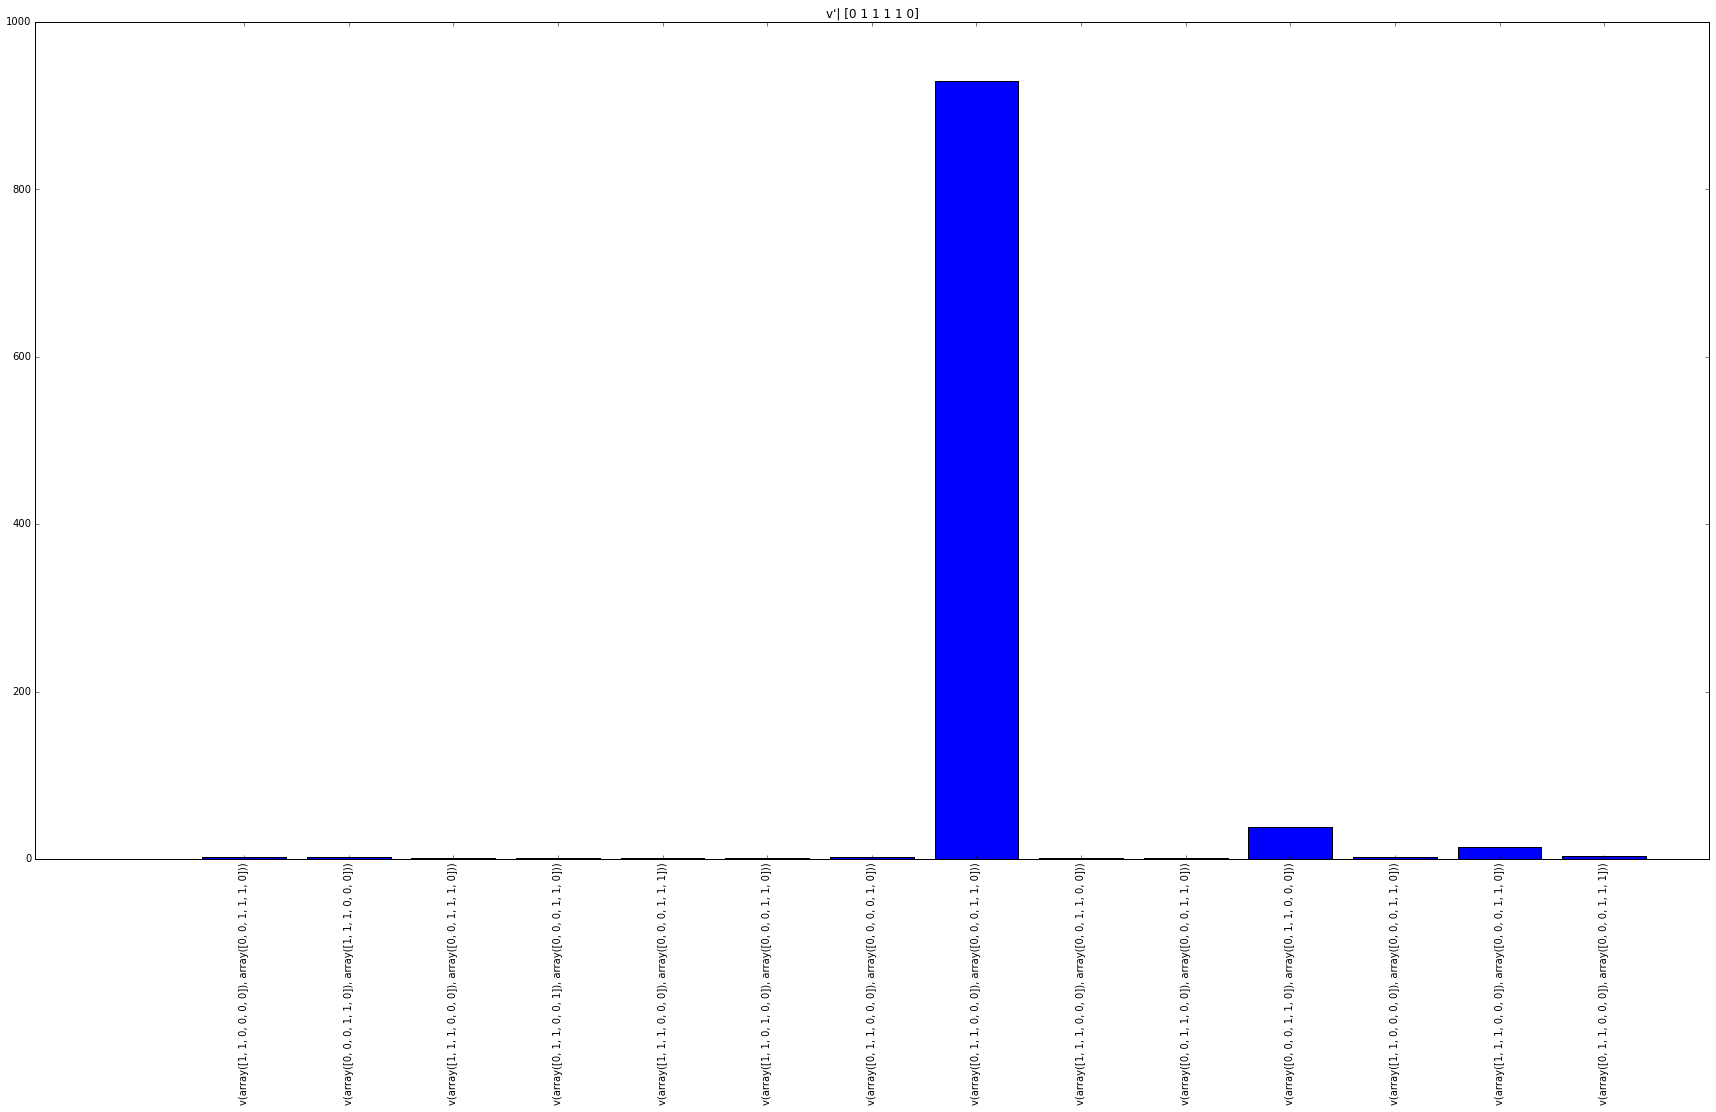

In [142]:
b = eval_partitioned(model, np.array([0,1,1,1,1,0]), num_gibbs=500)

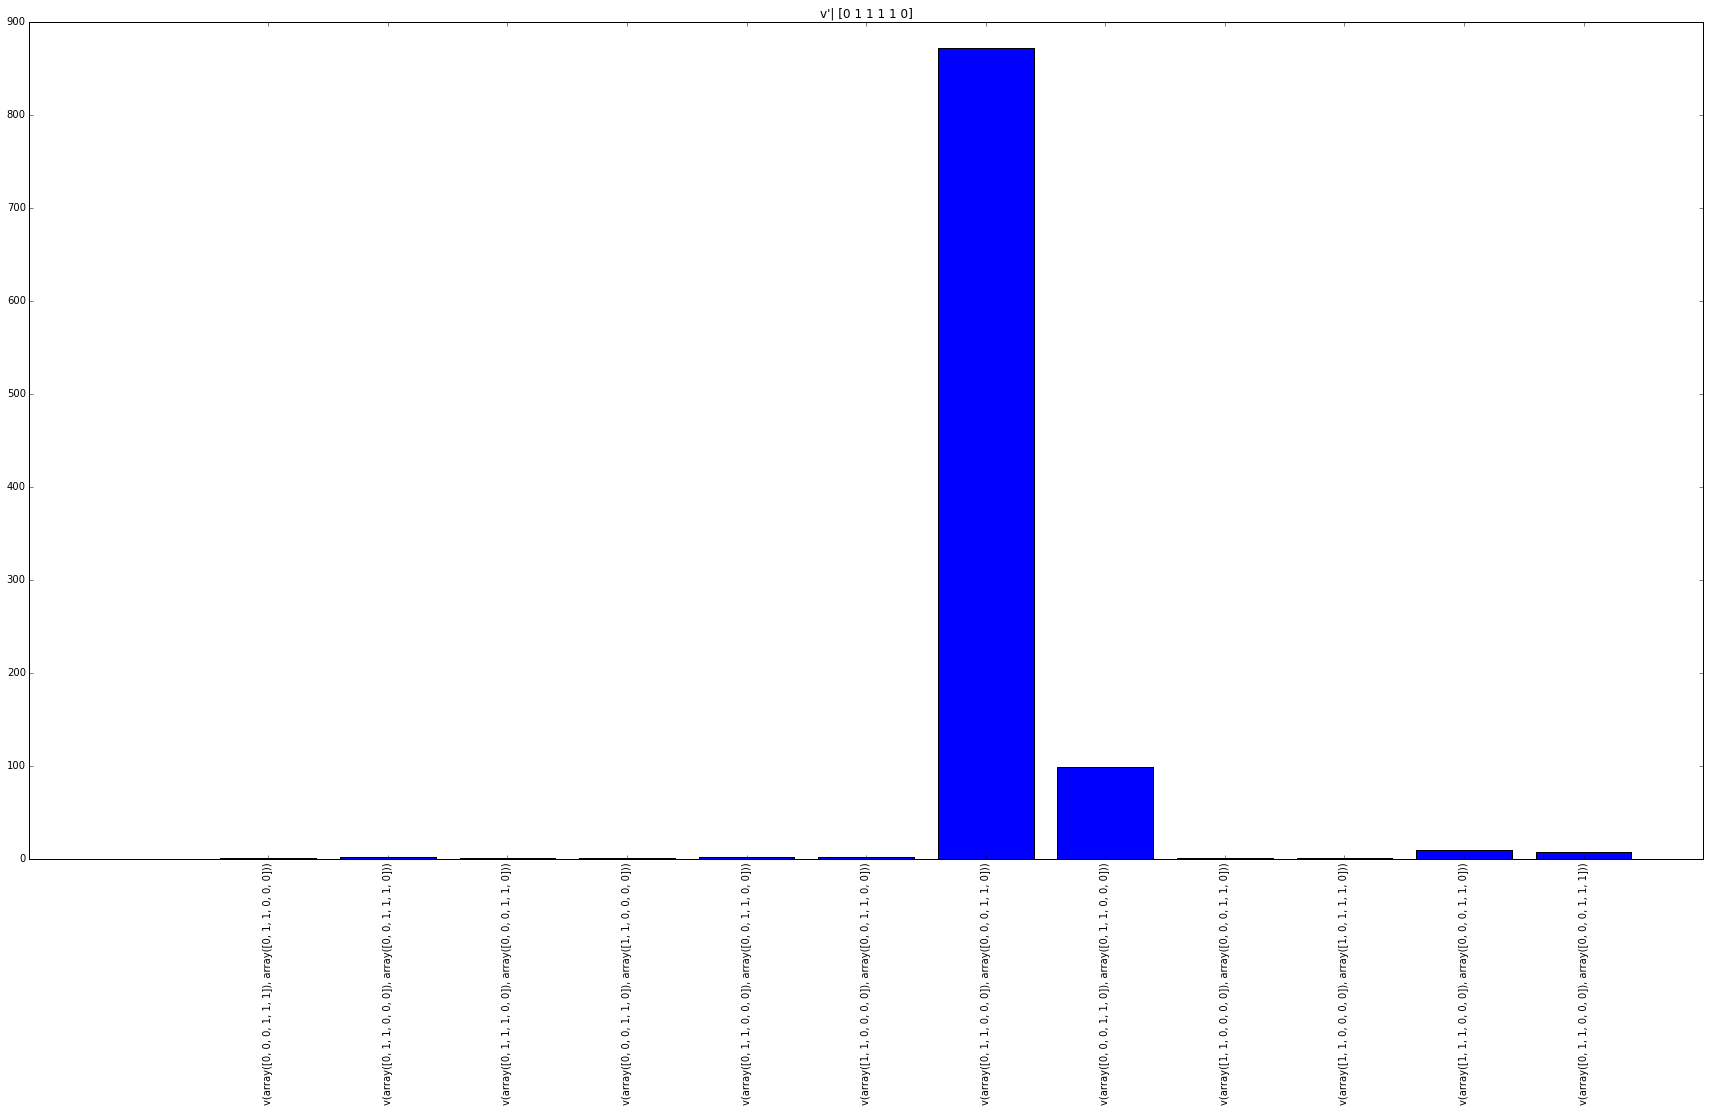

In [143]:
b = eval_partitioned(model, np.array([0,1,1,1,1,0]), num_gibbs=2000)

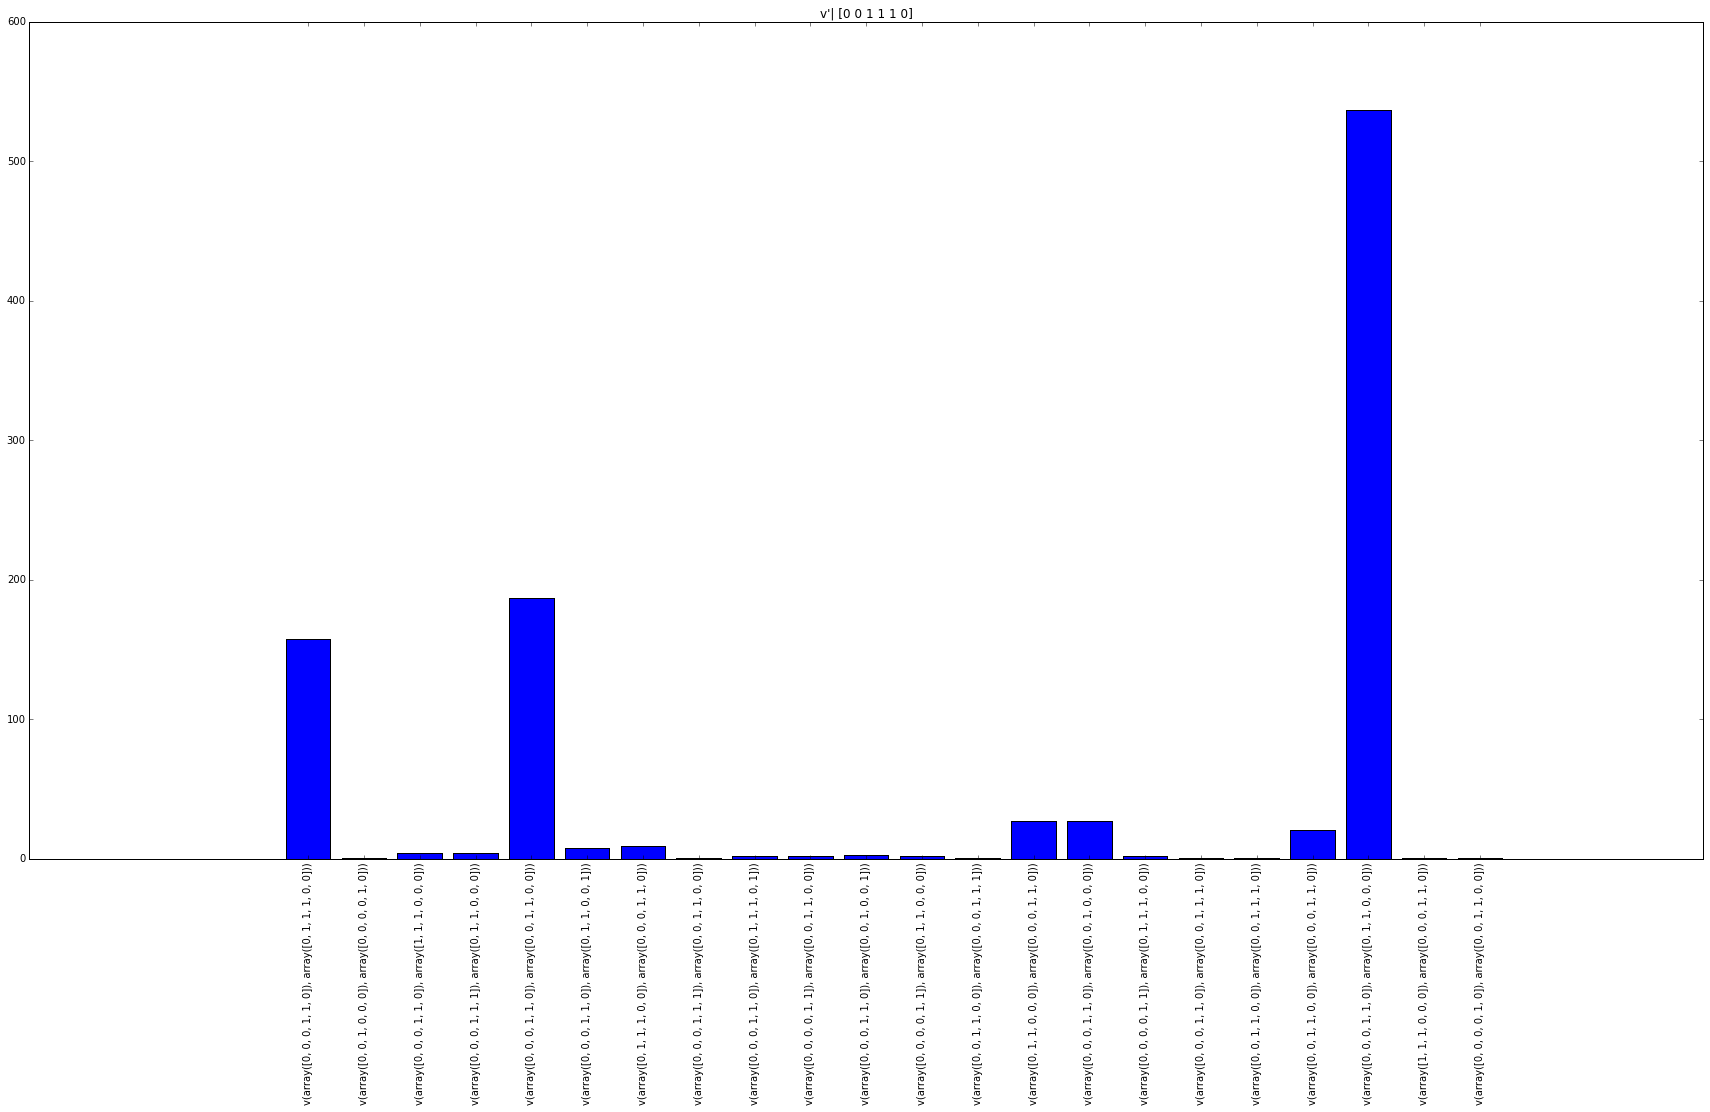

In [144]:
b = eval_partitioned(model, np.array([0,0,1,1,1,0]), num_gibbs=500)

[[ 1.  1.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  1.  1.]]


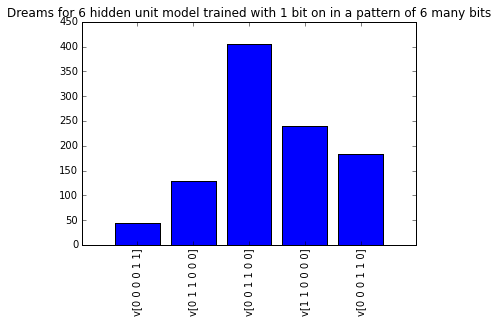

In [173]:
train = training_set_of_size(6)
print(train)
model = build_and_eval(train, 6,6,epochs=1000000,l_r=0.05)

# Five Bits, Three on

[[ 1.  1.  1.  0.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  0.  1.  1.  1.]]
Attempt[[ 1.  1.  1.  0.  0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  0.  1.  1.  1.]]
Attempt 0
 0


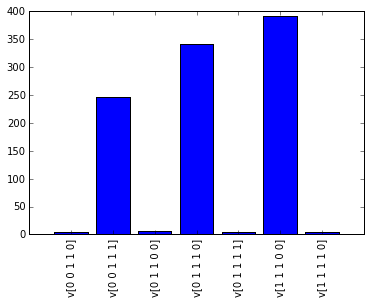

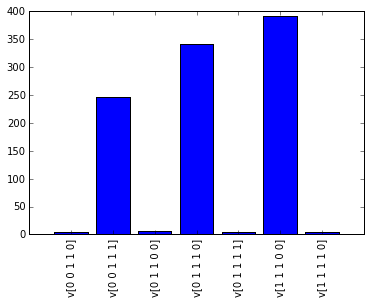

Penalty For 5h:153.66666666666669
AttemptPenalty For 5h:153.66666666666669
Attempt 0
 0


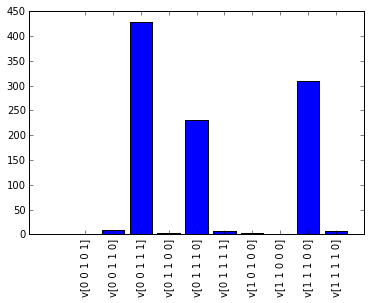

Penalty For 4h:212.33333333333331


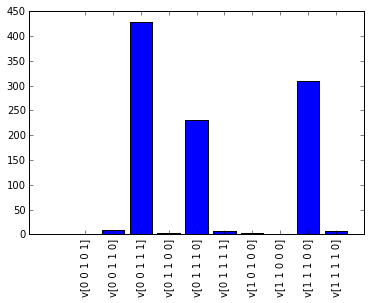

Penalty For 4h:212.33333333333331


In [12]:
train = training_set_of_size(5,3)
print(train)
five_hid = build_and_eval(train, 5,5)
four_hid = build_and_eval(train, 4,5)

In [14]:
composite

array([ 1.,  1.,  1.,  1.,  0.])

array([ 1.,  1.,  1.,  1.,  0.])

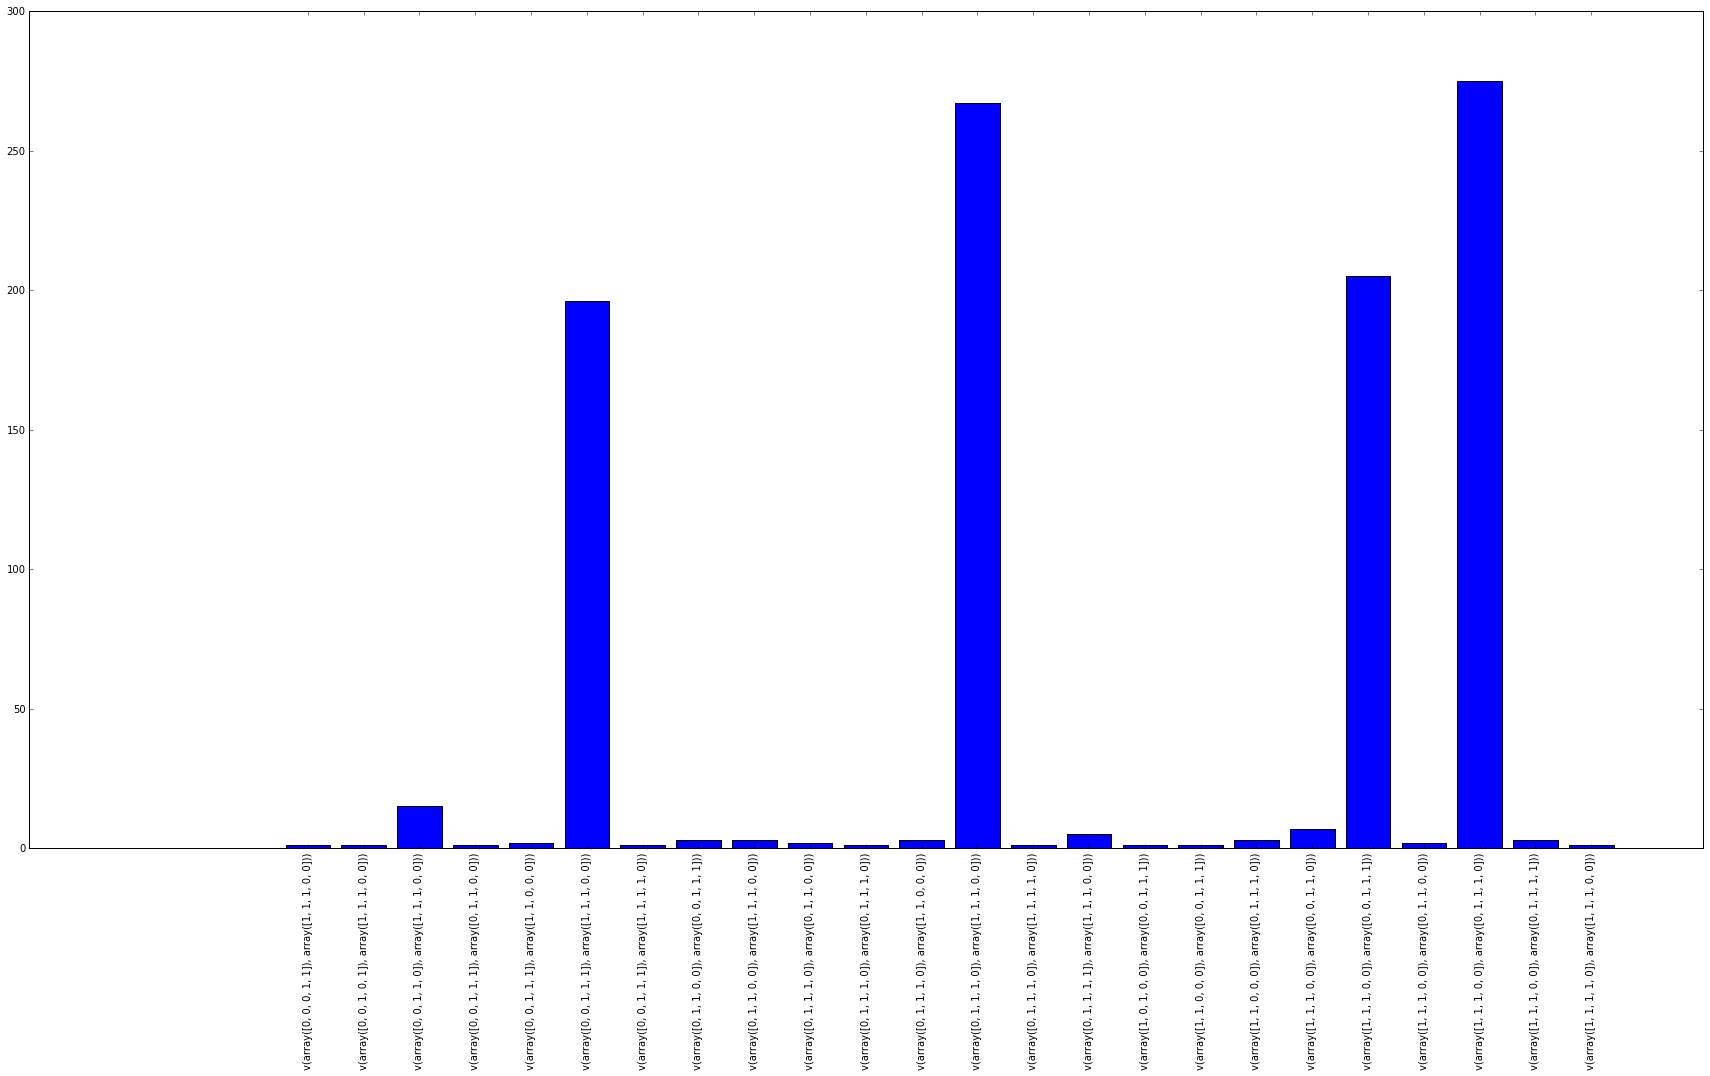

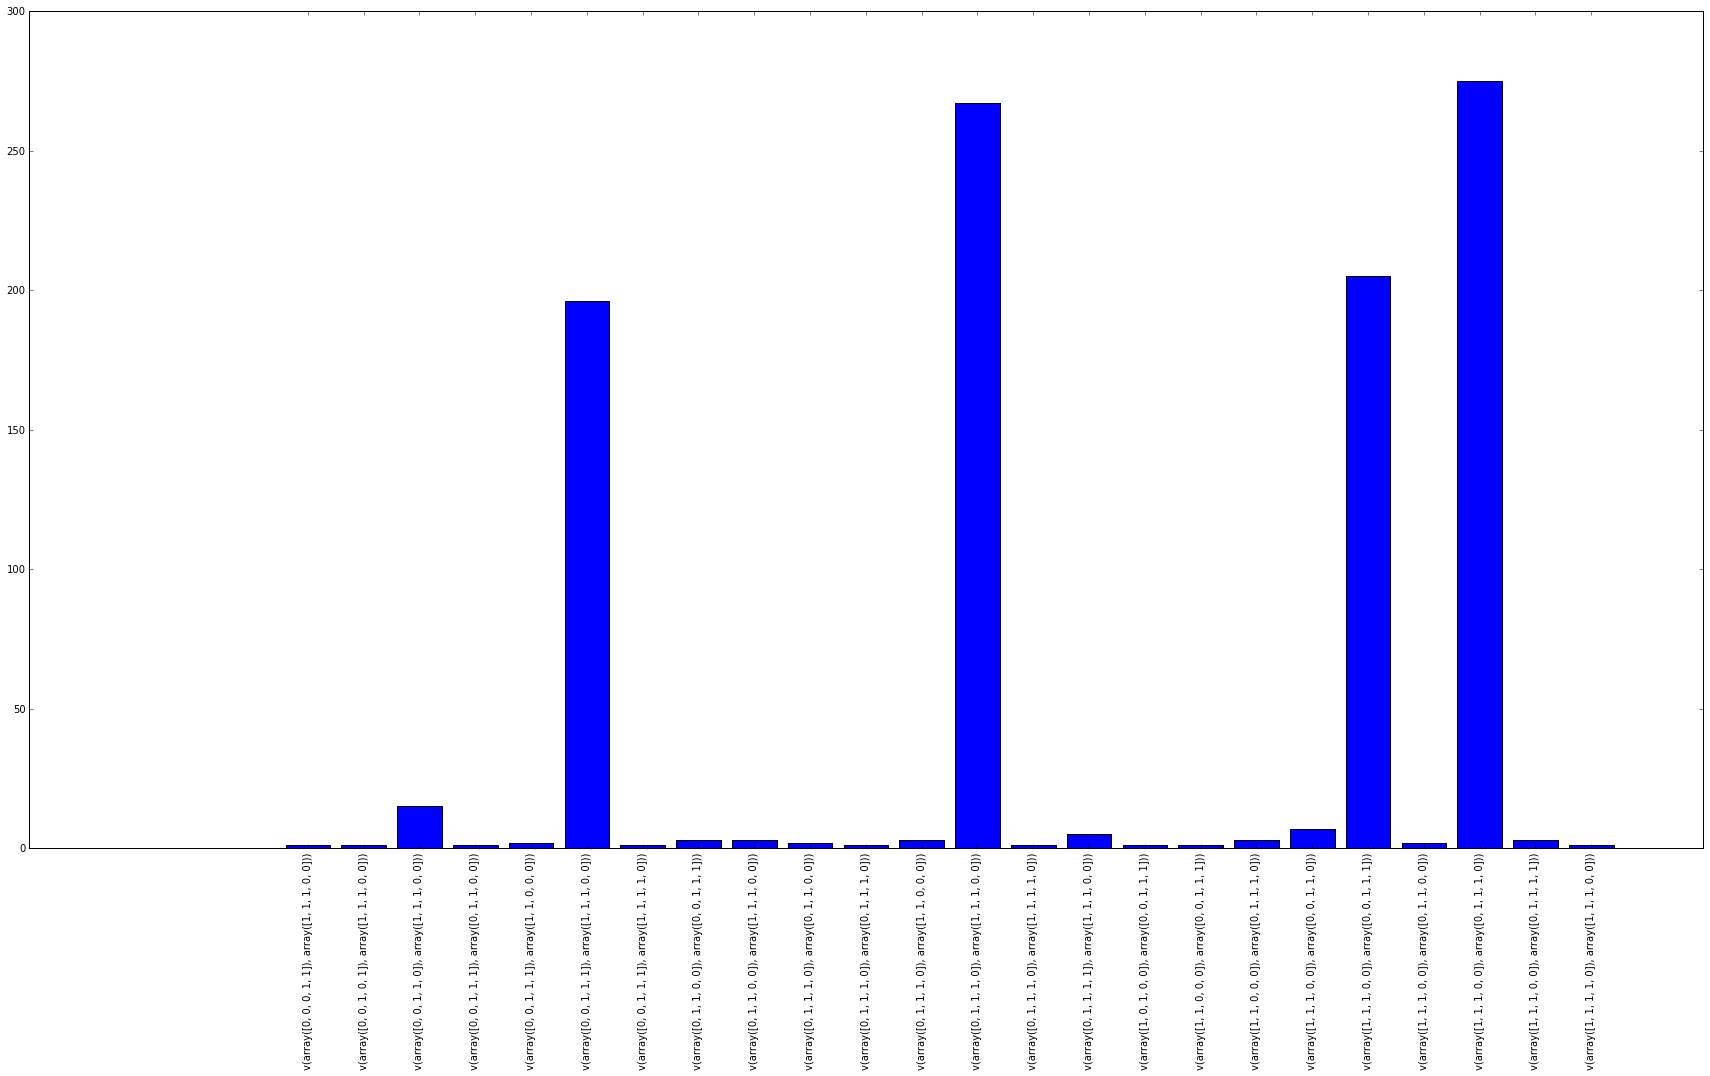

In [19]:
composite = np.maximum(train[0],train[1])
b = eval_partitioned(four_hid,composite, num_gibbs=500)
# b = eval_partitioned(four_hid,composite, num_gibbs=500, sampler = DirtySampler)

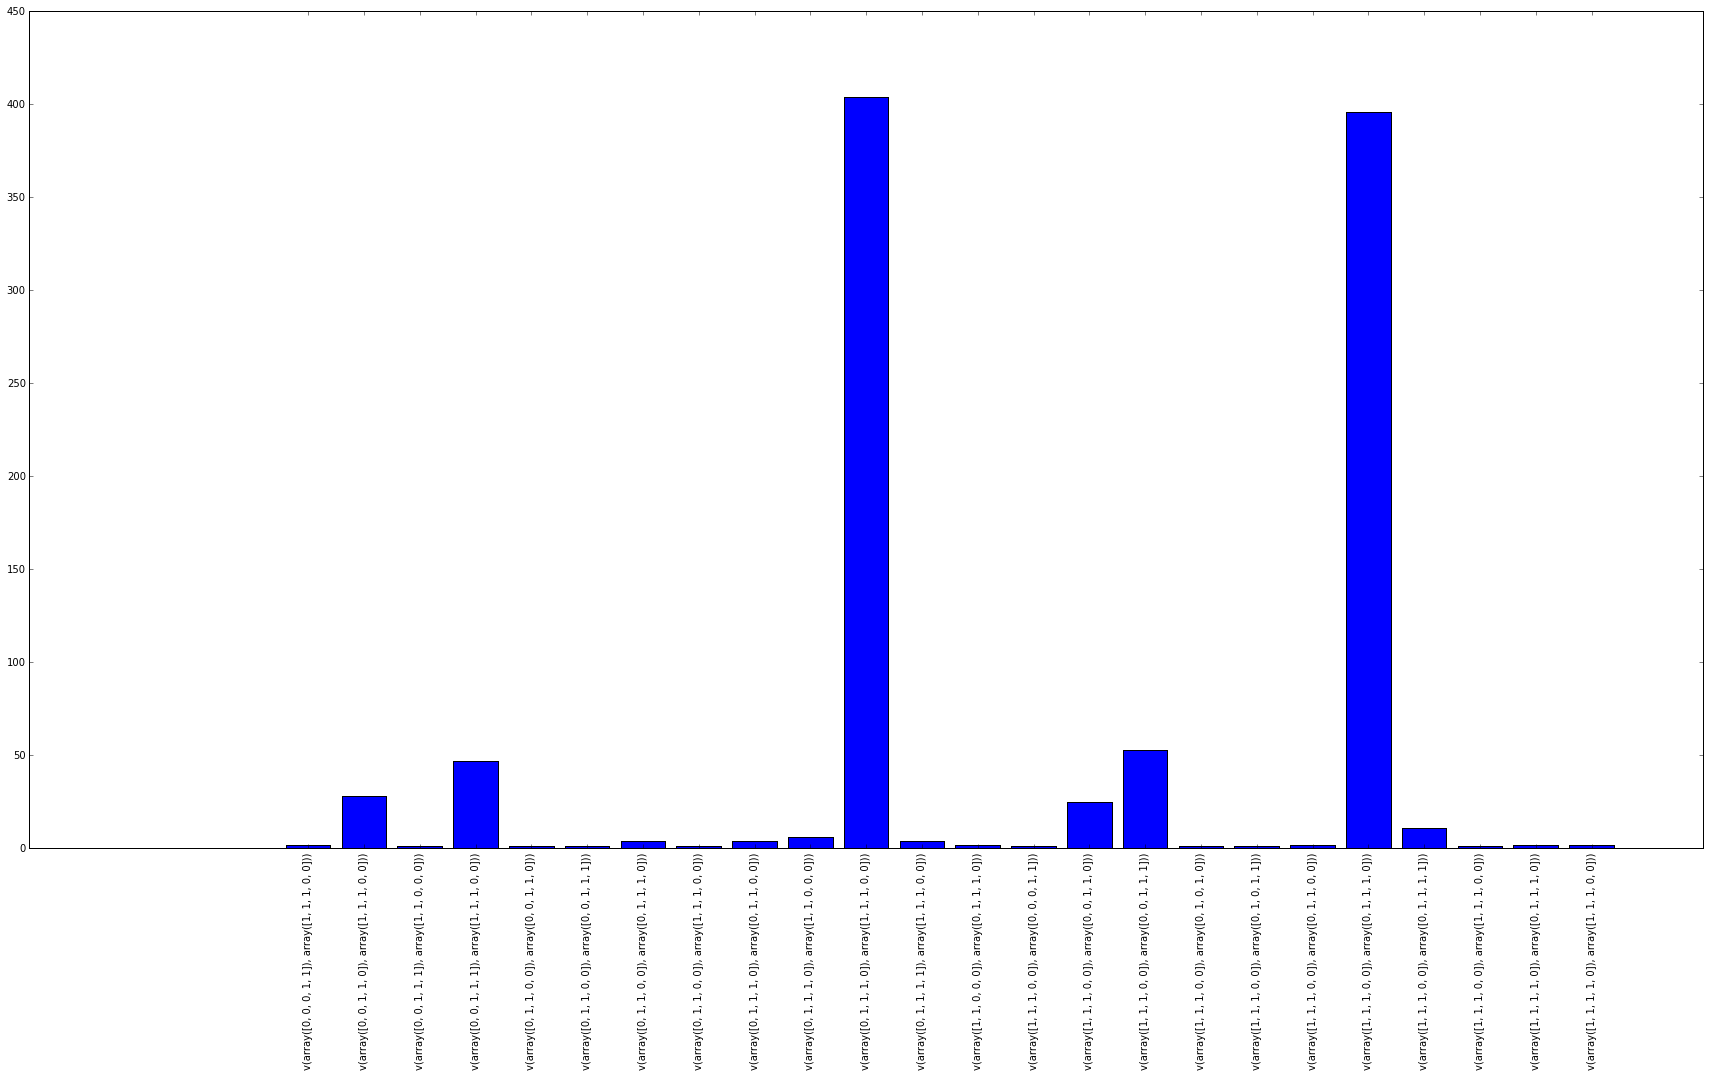

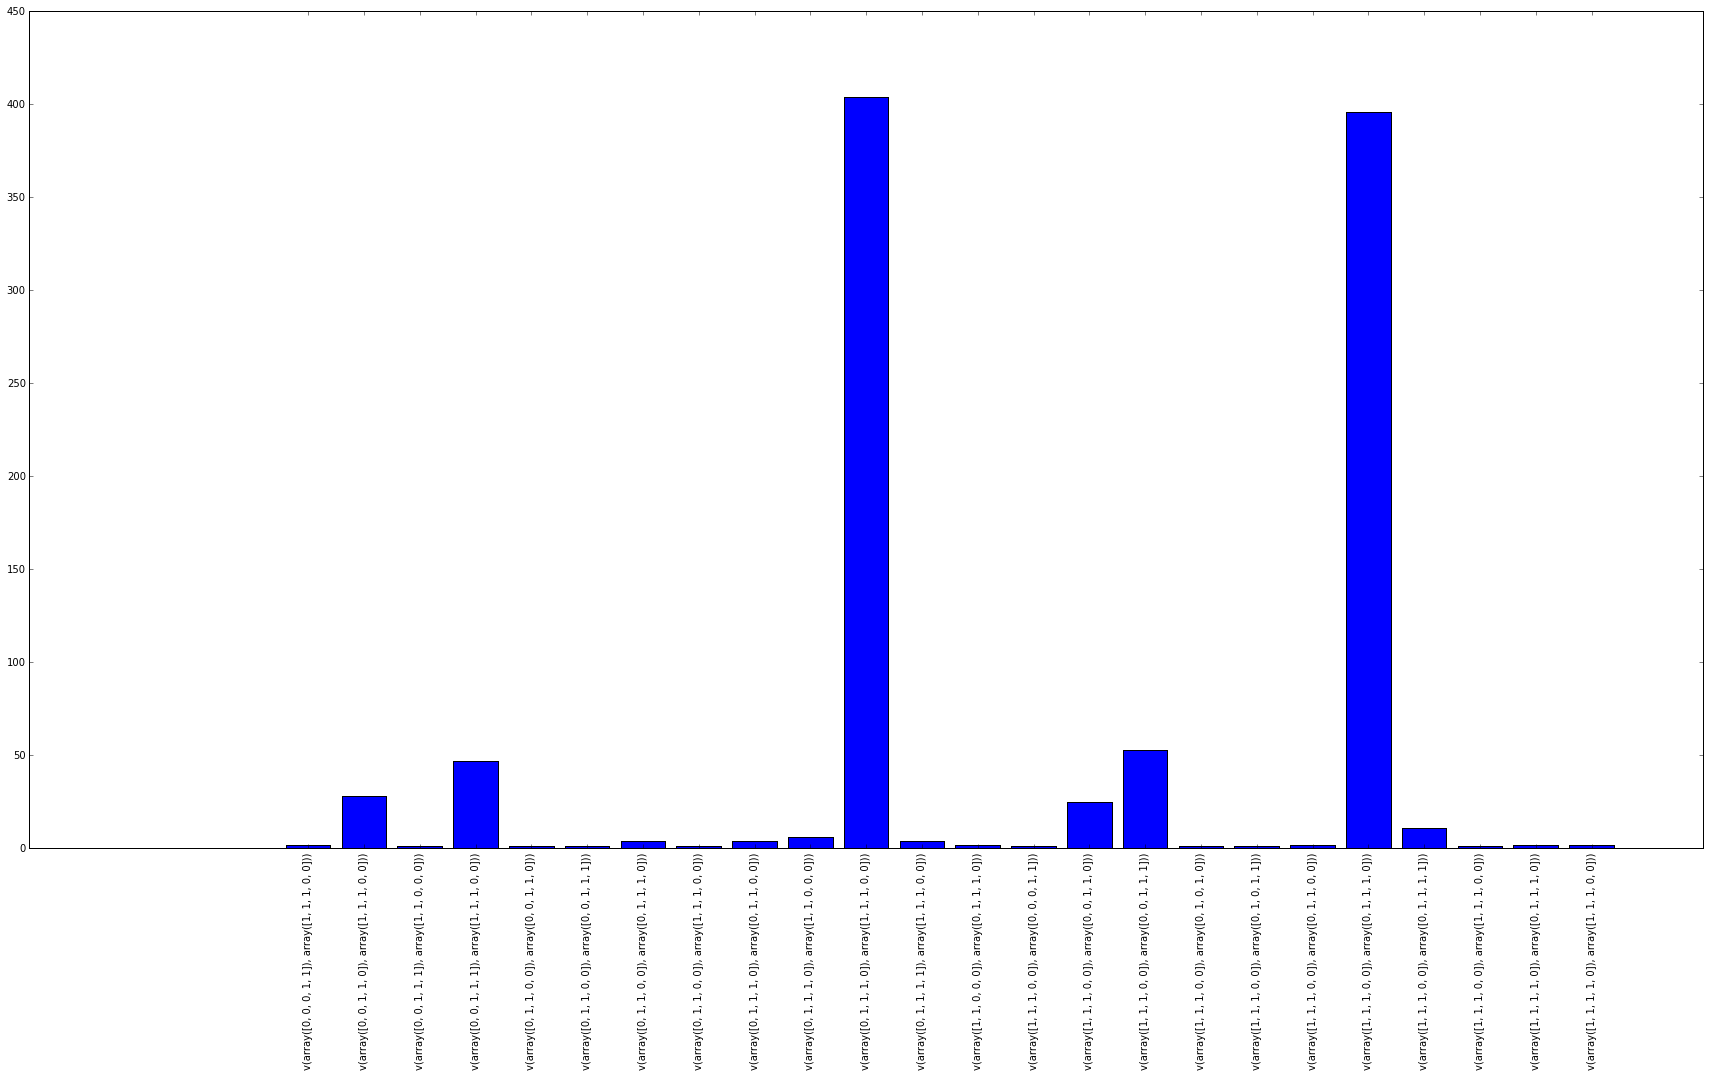

In [16]:
b = eval_partitioned(five_hid,composite, num_gibbs=500, sampler = ApproximatedSampler)

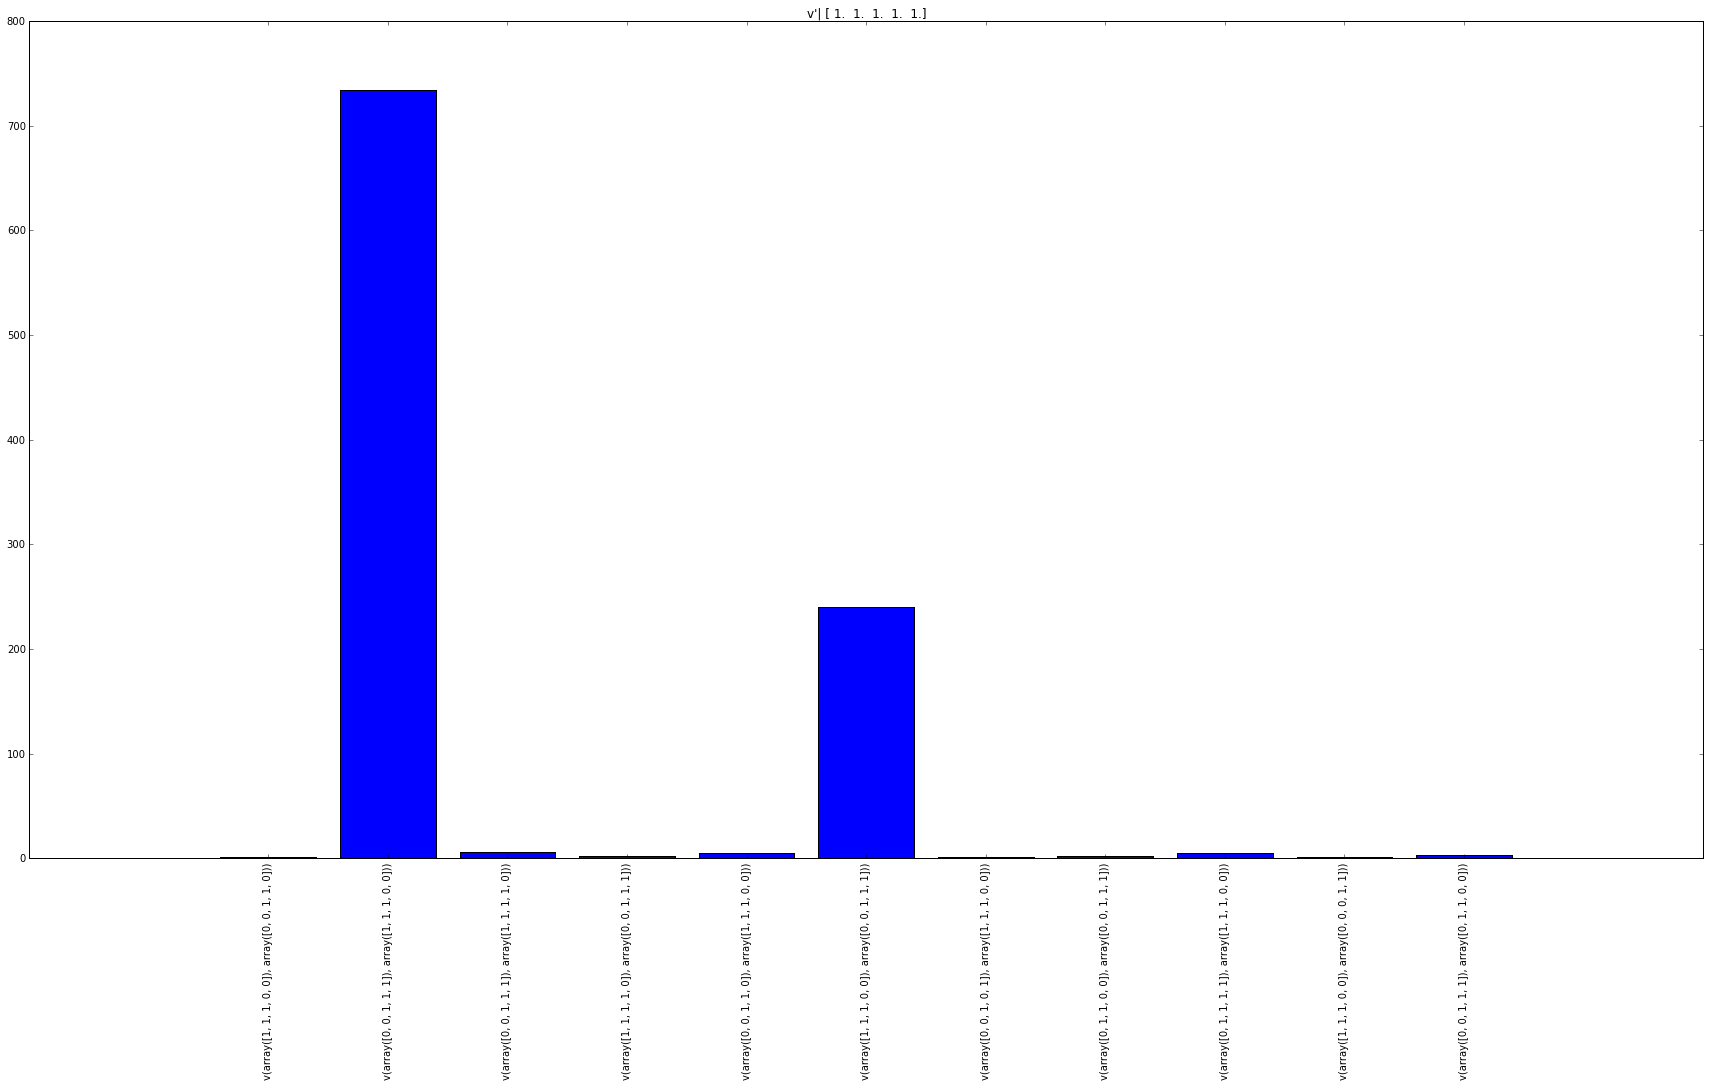

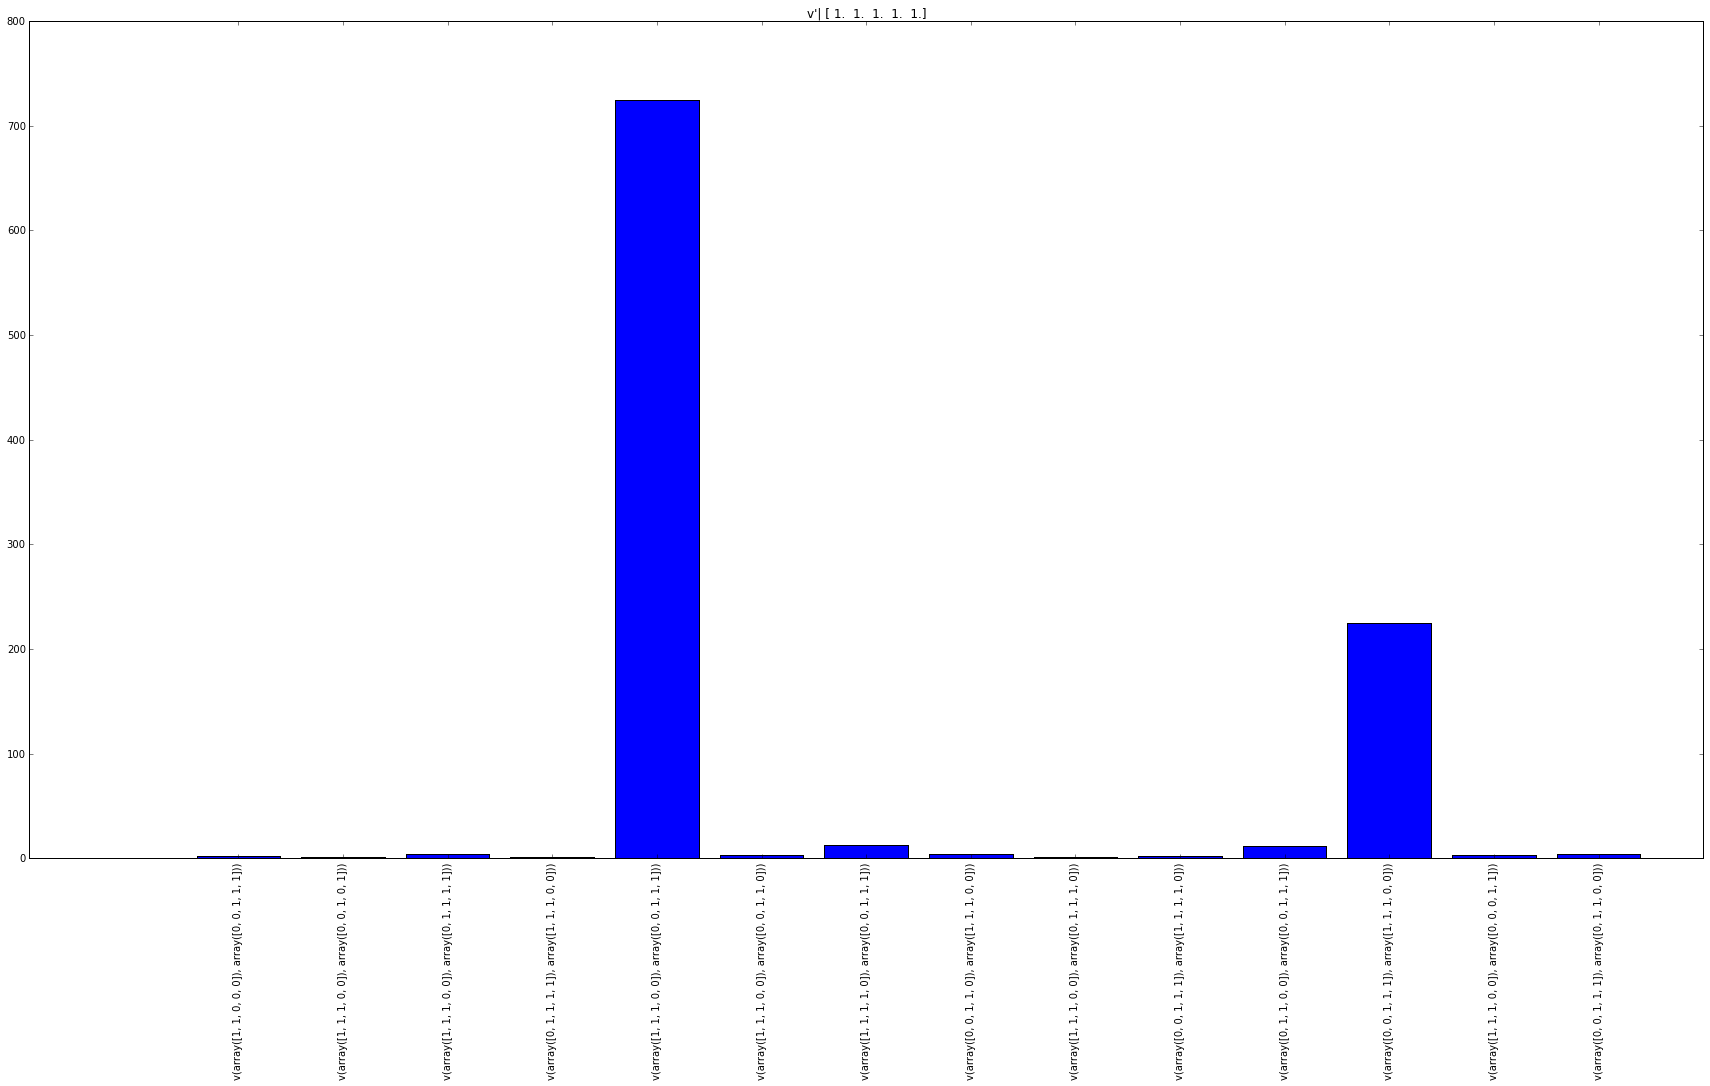

In [73]:
composite = np.maximum(train[0],train[2])
b = eval_partitioned(five_hid,composite, num_gibbs=500)
b = eval_partitioned(four_hid,composite, num_gibbs=500)

# Six Bits, Three on #

In [ ]:
train = training_set_of_size(6,3)
print(train)
six_hid = build_and_eval(train, 6,6,tries=1)

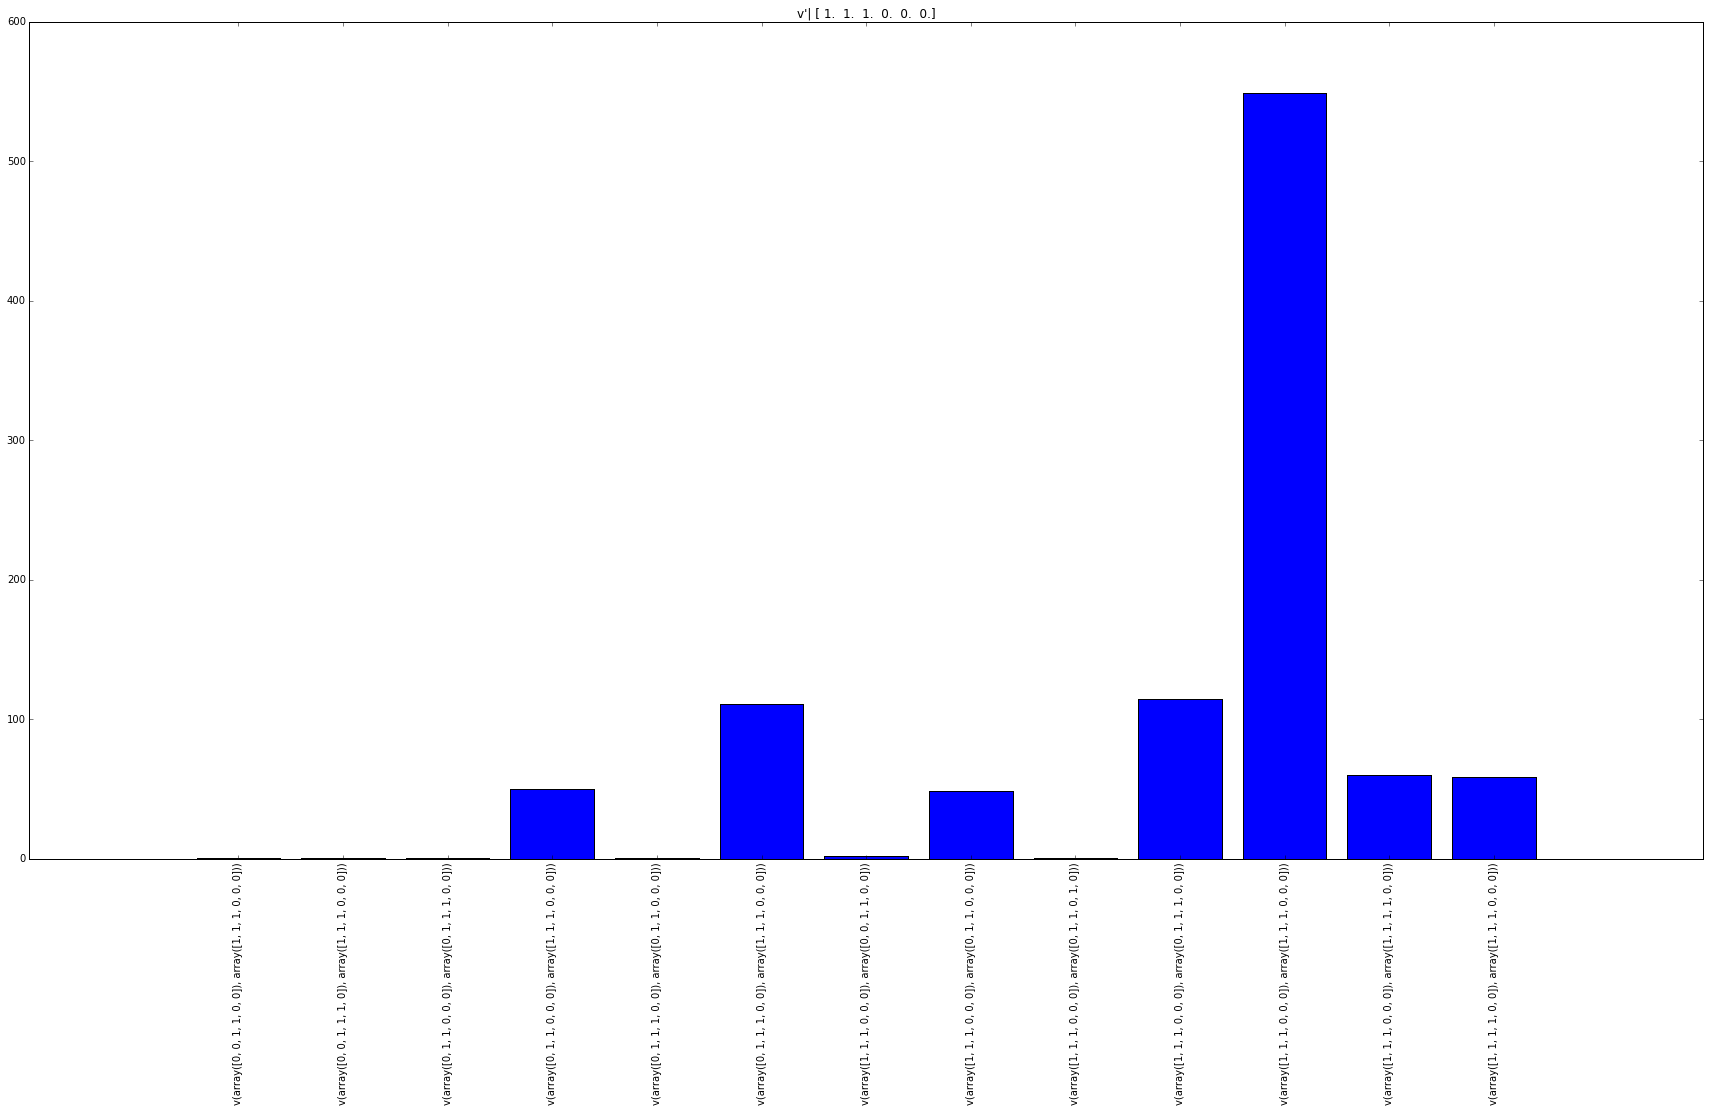

In [53]:
composite = np.maximum(train[0],train[0])
b = eval_partitioned(six_hid,composite, num_gibbs=500)